# <b><h1>Disco Data Processing Script</h1>
<h2>Part 1 Reading and Cleaning Data</h2></b>

Prior to running the script, please ensure you have inserted one raw book to be analyzed inside the input directory. At this time, the code only works for one book at a time, and will create custom output folders based on the name of the input book, so nothing overwrites. However right now, including multiple books in the input folder will result in erroneous data.
    
<b>Your Folder Should Look Like:</b>    
- disco-data-processing.py
- disco-data-processing.ipynb
- input/"raw_book_with_a_title_you_like.xlsx"
     

In [2]:
# importing required libraries:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot
from scipy.stats import t
import scipy.stats as stats
from scipy.optimize import curve_fit
import os 
import glob

In [3]:
#PART 1 -------- Reading in Data and Visualizing the Results

#assign local path to raw Excel book (code can only do one at a time for now)
raw_book_path = os.path.abspath('input')
print('Searching in directory:', raw_book_path, '\n')

#list all raw books in file
list_of_raw_books = glob.glob("input/*.xlsx")
print('List of raw books to be analyzed are: ', list_of_raw_books, '\n')


Searching in directory: /Users/s.stuart/Documents/Python/disco-data-processing/input 

List of raw books to be analyzed are:  ['input/PAA_for_Code_dataintegrity-2-newpaa20um.xlsx'] 



In [70]:
# CELL FOR TESTING A BETTER WAY TO RUN THIS CODE

#initialize a global list to hold all dataframes generated of Excel books analyzed in this script
clean_book_df_list = []

#Each loop iteration reviews the data of one raw book (i.e. one polymer) from the input folder - this loop would have to be expanded for whole code to do multi-book, and all outputs to files need to include book name
#For now - just put one book at a time in the input folder
for b in list_of_raw_books:
    
    current_book_title = os.path.basename(str(b))
    print("The current book being analyzed is: ", current_book_title)

    #determine the number of sheets, samples, & controls in the workbook
    name_sheets = pd.ExcelFile(b).sheet_names
    num_sheets = (len(pd.ExcelFile(b).sheet_names))
    
    #initialize number of samples and controls to zero, then initialize the "list initializers" which will hold book-level data to eventually add to the book-level dataframe.
    num_samples = 0
    num_controls = 0
    sample_control_initializer = []
    sample_replicate_initializer = []
    control_replicate_initializer = []
    
    #initialize a list to contain the many experimental dataframes collected within the current book, which will be concatenated at the end to create one dataframe "big_df" that represents this book
    df_list = []

    #loop through sheet names to determine number of samples and controls in this book
    for s in range(len(name_sheets)):
        
        #if the current sheet is labeled Sample: 
        #increment sample counter, add a list item called 'sample' to be initialized into the 'sample_or_control' list, add a list item of the replicate number to be initialized into the 'replicate' list.
        if ('Sample' or 'sample') in name_sheets[s]:
            num_samples += 1
            sample_control_initializer.append('sample')
            sample_replicate_initializer.append(num_samples)
            
        #if the current sheet is labeled Control: 
        #increment control counter, add a list item called 'control' to be initialized into the 'sample_or_control' list, add a list item of the replicate number to be initialized into the 'replicate' list.   
        elif ('Control' or 'control') in name_sheets[s]:
            num_controls += 1
            sample_control_initializer.append('control')
            control_replicate_initializer.append(num_controls)
    
    print("There are", num_sheets, "sheets identified in the current book.")
    print("Number of samples sheets identified:", num_samples)
    print("Number of control sheets identified:", num_controls)
    
    if num_samples != num_controls:
        print('\nERROR: The number of sample sheets is not equal to the number of control sheets in', b, 'please confirm the data in the book is correct.')
    
    #combine sample and control initializers to create the total replicate index list
    total_replicate_index = sample_replicate_initializer + control_replicate_initializer
    print("Sample and control data initialization complete at the book-level. Beginning experiment-specific data acquisition.")
    
    #FOR TESTING, can set num_sheets = 1
#     num_sheets = 1
    
    #loop through each sheet in the workbook
    for n in range(num_sheets):

        #read in the current book's nth sheet into a Pandas dataframe
        current_sheet_raw = pd.read_excel(b, sheet_name=n)
        print("Reading Book Sheet:", n)
        
        #if the name of the sheet is not a sample or control, skip this sheet and continue to the next one 
        if (any(['ample' not in name_sheets[n]]) & any(['ontrol' not in name_sheets[n]])):
            print("Skipping sheet", n, "as not a sample or control.")
            continue

        #drop first always empty unnamed col (NOTE - consider building error handling into this to check the col is empty first)
        to_drop = ['Unnamed: 0']
        current_sheet_raw.drop(columns = to_drop, inplace = True)

        #loop through columns and "fill right" to replace all Unnamed columns with their corresponding title_string value
        for c in current_sheet_raw.columns:
            current_sheet_raw.columns = [current_sheet_raw.columns[i-1] if 'Unnamed' in current_sheet_raw.columns[i] else current_sheet_raw.columns[i] for i in range(len(current_sheet_raw.columns))]

        #identifies the coordinates of the left-most parameter in each experimental set, conc (um)
        i, c = np.where(current_sheet_raw == 'conc (um)')

        #assigns coordinates of all upper left 'conc (um) cells to an index (row) array and a column array
        conc_indices = current_sheet_raw.index.values[i]
        conc_columns = current_sheet_raw.columns.values[c]

        #determine the number of experimental rows in each NMR results sub-table
        #subtract one to exclude conc cell row itself
        num_experimental_indices = np.unique(conc_indices)[2] - np.unique(conc_indices)[1] - 1
#         print("The number of experimental indices are:", num_experimental_indices)

        #determine the number of experimental columns in each NMR results sub-table
        (unique_exp_cols, count_experimental_cols) = np.unique(conc_columns, return_counts = True)
        num_experimental_cols = np.unique(count_experimental_cols)[0]
#         print("The number of experimental columns are:", num_experimental_cols)

        #initialize/reset dfs, current is for CURRENT sub-tables being looped over, big_df is to concatenate all the sub-dfs in this book
        current_exp_df = []
        big_df = []
        
        #make a list of coordinate pair tuples for this sheet using list comprehension
        sheet_coords_list = [(conc_indices[i], conc_columns[i]) for i in range(len(conc_indices))]

        for coords in sheet_coords_list:
        
            #Determine the current 'sample_or_control' and 'replicate' values by taking the nth value (aka current sheet value) from the lists determined above
            current_sample_or_control = sample_control_initializer[n]
            current_replicate = total_replicate_index[n]

            #assign current values to the fixed experimental parameters for this experimental sub-table
            fixed_parameters_per_set = current_sheet_raw.loc[coords[0], coords[1]]
    
            #Hard coding the indices of the different parameters based on constant pattern 
            current_title_string = fixed_parameters_per_set.index[0]
            current_concentration = fixed_parameters_per_set[1]
            current_sat_time = fixed_parameters_per_set[3]
            current_irrad_bool = fixed_parameters_per_set[5]

            #initialize/reset experimental lists to null for this experimental set
            list_current_ppm_experimental = []
            list_current_intensity_experimental = []
            list_current_width_experimental = []
            list_current_area_experimental = []
            list_current_type_experimental = []
            list_current_flags_experimental = []
            list_current_impuritycomp_experimental = []
            list_current_annotation_experimental = []
            list_current_range_experimental = []
            list_current_normalized_experimental = []
            list_current_absolute_experimental = []

            #  now need to find and assign the sub-table's actual experimental data to the new lists 
                
            # Initializing the "boundaries" of the sub-table containing values of interest in a generalizable way below
            experimental_index_starter = coords[0]+1
#             print("Experimental Index Starter is:", experimental_index_starter)

            experimental_index_range = range(num_experimental_indices)
#             print("Experimental Index Range is:", experimental_index_range)

            experimental_column_range = range(num_experimental_cols)
#             print("Experimental Column Range is:", experimental_column_range)

            combined_experimental_index_range = experimental_index_starter + experimental_index_range
#             print("Combined Experimental Index Range Type is:", type(combined_experimental_index_range))

            #Obtain experimental column range using boolean mask as column labels are title_strings for each experimental set
            experimental_column_range_mask = current_sheet_raw.columns.get_loc(coords[1])
    
            combined_experimental_column_range = np.where(experimental_column_range_mask)
#             print("Combined Experimental Column Range Type is:", type(combined_experimental_column_range))
            
            #loop through and collect experimental index and experimental column range for the ith and jth experimental sub-table
            for ei in combined_experimental_index_range:
                for ec in combined_experimental_column_range:
                    
#                 use iloc to grab NMR experimental variables for this set into a series
                    variable_parameters_per_set = current_sheet_raw.iloc[ei, ec]
#                     print(variable_parameters_per_set)

#             append designated variable parameters from the generated Series' into lists for those parameters for this experimental set
        #     hard coded based on known order of columns
                    list_current_ppm_experimental.append(variable_parameters_per_set.iloc[1])
                    list_current_intensity_experimental.append(variable_parameters_per_set.iloc[2])
                    list_current_width_experimental.append(variable_parameters_per_set.iloc[3])
                    list_current_area_experimental.append(variable_parameters_per_set.iloc[4])
                    list_current_type_experimental.append(variable_parameters_per_set.iloc[5])
                    list_current_flags_experimental.append(variable_parameters_per_set.iloc[6])
                    list_current_impuritycomp_experimental.append(variable_parameters_per_set.iloc[7])
                    list_current_annotation_experimental.append(variable_parameters_per_set.iloc[8])
                    list_current_range_experimental.append(variable_parameters_per_set.iloc[11])
                    list_current_normalized_experimental.append(variable_parameters_per_set.iloc[12])
                    list_current_absolute_experimental.append(variable_parameters_per_set.iloc[13])
                    

            #after all the experimental lists are populated, define length of the experimental parameter lists (number of true experimental rows)
            exp_list_length = len(list_current_ppm_experimental)
#                 print('Experimental List Length is:', exp_list_length)

            #create "ranged" lists of the constant experimental values to make them the same length as the unique variable experimental values, so we can add information "per observation" to the dataframe
            ranged_sample_or_control = exp_list_length * [current_sample_or_control]
#                 print(len(ranged_sample_or_control))
            ranged_replicate = exp_list_length * [current_replicate]
#                 print(len(ranged_replicate))
            ranged_title_string = exp_list_length * [current_title_string]
#                 print(len(ranged_title_string))
            ranged_concentration = exp_list_length * [current_concentration] 
#                 print(len(ranged_concentration))
            ranged_sat_time = exp_list_length * [current_sat_time]
#                 print(len(ranged_sat_time))
            ranged_irrad_bool = exp_list_length * [current_irrad_bool]
#                 print(len(ranged_irrad_bool))
                

            #assign all current experimental values for this experimental set to a dataframe via a dictionary
            current_dict = {"sample_or_control":ranged_sample_or_control,
                                "replicate":ranged_replicate,
                                "title_string":ranged_title_string, 
                                "concentration":ranged_concentration,
                                "sat_time":ranged_sat_time, 
                                "irrad_bool":ranged_irrad_bool, 
                                "ppm":list_current_ppm_experimental, 
                                "intensity":list_current_intensity_experimental, 
                                "width":list_current_width_experimental, 
                                "area":list_current_area_experimental, 
                                "type":list_current_type_experimental, 
                                "flags":list_current_flags_experimental, 
                                "impurity_compound":list_current_impuritycomp_experimental, 
                                "annotation":list_current_annotation_experimental, 
                                "range":list_current_range_experimental, 
                                "normalized":list_current_normalized_experimental, 
                                "absolute":list_current_absolute_experimental}
            
            current_exp_df = pd.DataFrame(current_dict)
    
            #before moving on to next experimental set, append the dataframe from this experimental set to a book-level list of dataframes
            df_list.append(current_exp_df)

        print("Data frame for the experimental set at coordinates:", coords, "has been appended to the global list of dataframes.")
#     print("Data frame for the experimental set at coordinates:", conc_indices, conc_columns, "has been appended to the global list of dataframes.") 
    
    #after looping through all sheets in the book, and after appending all experimental dataframes from each sheet to a list...
    #concatenate the global list of dataframes into one big beautiful clean dataframe!
    big_df = pd.concat(df_list)
    print("The current book has been concatenated into a dataframe!")

    #Before looping to the next book, append big_df containing the current book to the global list "clean_book_df_list"
    clean_book_df_list.append(big_df)

# After looping through all books in the input folder, concatenate all book level dataframes into one collective dataframe, title strings will be unique
# Collective books is a bad name for this dataframe, it will just be the information of the one dataframe in the folder. In the future will expand for multiple books.
collective_books_df = pd.concat(clean_book_df_list)
print("Done - the information from this book has been concatenated into one big beautiful dataframe! Book: ", current_book_title)


The current book being analyzed is:  PAA_for_Code_dataintegrity-2-newpaa20um.xlsx
There are 13 sheets identified in the current book.
Number of samples sheets identified: 6
Number of control sheets identified: 6
Sample and control data initialization complete at the book-level. Beginning experiment-specific data acquisition.
Reading Book Sheet: 0
Data frame for the experimental set at coordinates: (66, 'from 20190708-PAA Association 10um (First Difference - Individual Correction)') has been appended to the global list of dataframes.
Reading Book Sheet: 1
Data frame for the experimental set at coordinates: (66, 'from 20190722 PAA Association 10um (First Difference - Individual Correction) (n=2)') has been appended to the global list of dataframes.
Reading Book Sheet: 2
Data frame for the experimental set at coordinates: (66, 'from 20200319-4-10umPAA') has been appended to the global list of dataframes.
Reading Book Sheet: 3
Data frame for the experimental set at coordinates: (66, 'from 

In [71]:
collective_books_df

,sample_or_control,replicate,title_string,concentration,sat_time,irrad_bool,ppm,intensity,width,area,type,flags,impurity_compound,annotation,range,normalized,absolute
0,sample,1,from 20190708 PAA Association 30um,30.0,0.25,1.0,ppm,Intensity,Width,Area,Type,Flags,Impurity/Compound,Annotation,Range,Normalized,Absolute
1,sample,1,from 20190708 PAA Association 30um,30.0,0.25,1.0,1.9863,129.795,58,135161,Compound,None,NaN,NaN,2.2029 .. 1.8477,2.8,108785
2,sample,1,from 20190708 PAA Association 30um,30.0,0.25,1.0,1.5215,76.2,44.78,61267.4,Compound,None,NaN,NaN,1.6178 .. 1.4610,1.15,44704.6
3,sample,1,from 20190708 PAA Association 30um,30.0,0.25,1.0,1.3678,94.334,60.46,102394,Compound,None,NaN,NaN,1.4610 .. 1.0950,3.06,118934
0,sample,1,from 20200319-4-25umPAA,25.0,0.25,1.0,ppm,Intensity,Width,Area,Type,Flags,Impurity/Compound,Annotation,Range,Normalized,Absolute
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,control,6,from 20200831-2-12p5umPAA,12.5,1.75,0.0,1.3779,30.8905,76.03,42166.3,Compound,None,NaN,NaN,1.4610 .. 1.0950,1.97,42187.8
0,control,6,from 20200831-2-10umPAA,10.0,1.75,0.0,ppm,Intensity,Width,Area,Type,Flags,Impurity/Compound,Annotation,Range,Normalized,Absolute
1,control,6,from 20200831-2-10umPAA,10.0,1.75,0.0,1.9802,35.9066,58.78,37890.4,Compound,None,NaN,NaN,2.2029 .. 1.8477,2.11,35524.9
2,control,6,from 20200831-2-10umPAA,10.0,1.75,0.0,1.5083,17.6881,19.69,6251.49,Compound,None,NaN,NaN,1.6178 .. 1.4610,0.97,16227.9


In [73]:
# UNCOMMENT THIS SECTION TO EXPORT THE RAW OUTPUT OF THE DATA COLLECTION CODE TO EXCEL AND VIEW IT BELOW ---------------------------

# # export collective book to excel output, only works for b = 1 at this stage, would need to incorporate this into loop to do multi-book
# output_directory = "output"
# output_file_name = "{}_dirty_dataframe.xlsx".format(current_book_title)

# #make directory if there isn't already one for output 
# if not os.path.exists(output_directory):
#     os.makedirs(output_directory)
    
# print('Exporting the dirty dataframe to output directory... this may take a moment.')
# collective_books_df_clean.to_excel(os.path.join(output_directory, output_file_name))

# print('Export complete! Navigate to output directory to see the clean Excel file.')
# collective_books_df

# ---------------------------------------------------------------------------------

In [74]:
#drop the file extension from current book title for easier file naming in the rest of the code
sep = '.'
current_book_title = current_book_title.split(sep, 1)[0]

In [75]:
#THIS CODE CLEANS THE RAW BOOK-LEVEL DATAFRAME EXPORTED FROM THE DATA PROCESSING CODE -----------------

#Need to remove redundant rows (generated by the data processing loops above)

#assign prosepctive redundant title rows at index zero to a variable
collective_books_df_redundant = collective_books_df[collective_books_df.index == 0]

#to make sure prospective redundant rows are actually redundant, check if there is only one unique intensity value in these suspect rows (i.e. suspect rows only contain the title value for intensity, indicating they are redundant)
if collective_books_df_redundant.nunique().loc['absolute'] == 1:
    collective_books_df_clean = collective_books_df[collective_books_df.index != 0]
else: 
    print("error, assumed redundant rows for further processing are not actually redundant. Proceed with this in mind.")
    collective_books_df_clean = collective_books_df
    
#remove duplicate rows
collective_books_df_clean = collective_books_df_clean.drop_duplicates()

#export cleaned dataframe of the book to excel output, only works for b = 1 at this stage, would need to incorporate this into loop to do multi-book
output_directory = "output_from_{}".format(current_book_title)
# output_file_name = "{}_converted_dataframe_output.xlsx".format(b)
output_file_name = "{}_clean_raw_dataframe.xlsx".format(current_book_title)

#make directory if there isn't already one for output 
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    
print('Exporting cleaned book dataframe for all provided books to output directory... this may take a moment.')
collective_books_df_clean.to_excel(os.path.join(output_directory, output_file_name))

print('Export complete! Navigate to output directory to see the clean Excel file.')
collective_books_df_clean

Exporting cleaned book dataframe for all provided books to output directory... this may take a moment.
Export complete! Navigate to output directory to see the clean Excel file.


,sample_or_control,replicate,title_string,concentration,sat_time,irrad_bool,ppm,intensity,width,area,type,flags,impurity_compound,annotation,range,normalized,absolute
1,sample,1,from 20190708 PAA Association 30um,30.0,0.25,1.0,1.9863,129.795,58,135161,Compound,None,NaN,NaN,2.2029 .. 1.8477,2.8,108785
2,sample,1,from 20190708 PAA Association 30um,30.0,0.25,1.0,1.5215,76.2,44.78,61267.4,Compound,None,NaN,NaN,1.6178 .. 1.4610,1.15,44704.6
3,sample,1,from 20190708 PAA Association 30um,30.0,0.25,1.0,1.3678,94.334,60.46,102394,Compound,None,NaN,NaN,1.4610 .. 1.0950,3.06,118934
1,sample,1,from 20200319-4-25umPAA,25.0,0.25,1.0,1.9861,104.043,60.4,112814,Compound,None,NaN,NaN,2.2029 .. 1.8477,1.98,88020.3
2,sample,1,from 20200319-4-25umPAA,25.0,0.25,1.0,1.52,61.2404,47.64,52376.2,Compound,None,NaN,NaN,1.6178 .. 1.4610,0.84,37472.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,control,6,from 20200831-2-12p5umPAA,12.5,1.75,0.0,1.5091,22.9277,44.01,18115.4,Compound,None,NaN,NaN,1.6178 .. 1.4610,0.94,20118.9
3,control,6,from 20200831-2-12p5umPAA,12.5,1.75,0.0,1.3779,30.8905,76.03,42166.3,Compound,None,NaN,NaN,1.4610 .. 1.0950,1.97,42187.8
1,control,6,from 20200831-2-10umPAA,10.0,1.75,0.0,1.9802,35.9066,58.78,37890.4,Compound,None,NaN,NaN,2.2029 .. 1.8477,2.11,35524.9
2,control,6,from 20200831-2-10umPAA,10.0,1.75,0.0,1.5083,17.6881,19.69,6251.49,Compound,None,NaN,NaN,1.6178 .. 1.4610,0.97,16227.9


In [76]:
def attenuation_calc_equality_checker(compare_df_1, compare_df_2):
    
    '''This functions checks to see if two subset dataframes for the attenuation calculation, one where irrad bool is true, one where irrad bool is false, for calculating attenuation
    are equal and in the same order in terms of their fixed experimental parameters. 'sample_or_control', 'replicate', 'title_string', 'concentration', 
    'sat_time' '''
    
    if (compare_df_1.shape == compare_df_2.shape):
        
        subset_compare_1 = compare_df_1[['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time']]
        subset_compare_2 = compare_df_2[['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time']]
        exactly_equal = subset_compare_2.equals(subset_compare_1)
    
        return exactly_equal
        
    else:
        return print("Error, irrad_false and irrad_true dataframes are not the same shape to begin with.")

def corrected_attenuation_calc_equality_checker(compare_df_1, compare_df_2, compare_df_3):  
    
    '''This functions checks to see if the three subset dataframes for calculating the corrected % attenuation
    are equal and in the same order in terms of their shared fixed experimental parameters. 'replicate', 'concentration', 
    'sat_time' '''
    
    #check if number of rows same in each df, number of columns not same as samples dfs contain attenuation data
    if (compare_df_1.shape[0] == compare_df_2.shape[0] == compare_df_3.shape[0]):
        
        subset_compare_1 = compare_df_1[['replicate', 'concentration', 'sat_time']]
        subset_compare_2 = compare_df_2[['replicate', 'concentration', 'sat_time']]
        subset_compare_3 = compare_df_3[['replicate', 'concentration', 'sat_time']]
        exactly_equal_1 = subset_compare_2.equals(subset_compare_1)
        
        if exactly_equal_1 == True:
            exactly_equal_2 = subset_compare_3.equals(subset_compare_2)
            return exactly_equal_2
        
        else: return exactly_equal_1
        
    else:
        return print("Error, corrected % attenuation input dataframes are not the same shape to begin with.")

In [77]:
# get % attenuation of peak integral, true and false irrad dataframes below are one to one, so can perform simple subtraction
intensity_irrad_true = collective_books_df_clean.loc[(collective_books_df_clean['irrad_bool'] == 1.0), ['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time', 'ppm', 'intensity', 'range', 'normalized', 'absolute']]
intensity_irrad_false = collective_books_df_clean.loc[(collective_books_df_clean['irrad_bool'] == 0.0), ['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time', 'ppm', 'intensity', 'range', 'normalized', 'absolute']]

#check if the fixed experimental values in irrad true and irrad false are equal, in the same order, and the same size, so that one to one calculations can be performed to calculate attenuation.
fixed_values_equality_check = attenuation_calc_equality_checker(intensity_irrad_true, intensity_irrad_false)

if fixed_values_equality_check == True:
    p_attenuation_intensity = intensity_irrad_false[['absolute']] - intensity_irrad_true[['absolute']]

    #Update irradiated dataframe to include the % attenuation of the irradiated samples and controls
    intensity_irrad_true['attenuation'] = p_attenuation_intensity
else:
    print("Error, intensity_irrad true and false dataframes are not equal, cannot compute signal attenutation in a one-to-one manner.")

#print dataframe:
intensity_irrad_true

,sample_or_control,replicate,title_string,concentration,sat_time,ppm,intensity,range,normalized,absolute,attenuation
1,sample,1,from 20190708 PAA Association 30um,30.0,0.25,1.9863,129.795,2.2029 .. 1.8477,2.8,108785,1064.17
2,sample,1,from 20190708 PAA Association 30um,30.0,0.25,1.5215,76.2,1.6178 .. 1.4610,1.15,44704.6,463.339
3,sample,1,from 20190708 PAA Association 30um,30.0,0.25,1.3678,94.334,1.4610 .. 1.0950,3.06,118934,1287.68
1,sample,1,from 20200319-4-25umPAA,25.0,0.25,1.9861,104.043,2.2029 .. 1.8477,1.98,88020.3,1045.33
2,sample,1,from 20200319-4-25umPAA,25.0,0.25,1.52,61.2404,1.6178 .. 1.4610,0.84,37472.9,414.921
...,...,...,...,...,...,...,...,...,...,...,...
2,control,6,from 20200831-2-12p5umPAA,12.5,1.75,1.509,21.5999,1.6178 .. 1.4610,0.94,18939.7,1179.24
3,control,6,from 20200831-2-12p5umPAA,12.5,1.75,1.3778,29.112,1.4610 .. 1.0950,1.97,39724.1,2463.68
1,control,6,from 20200831-2-10umPAA,10.0,1.75,1.9803,33.7312,2.2029 .. 1.8477,2.12,33337,2187.91
2,control,6,from 20200831-2-10umPAA,10.0,1.75,1.5086,16.6053,1.6178 .. 1.4610,0.97,15256.1,971.801


In [78]:
#calculate the corrected % attenuation:

#subset the dataframe where irrad is true for samples only
p_atten_intensity_sample = intensity_irrad_true.loc[(intensity_irrad_true['sample_or_control'] == 'sample')]
#subset the dataframe where irrad is true for controls only
p_atten_intensity_control = intensity_irrad_true.loc[(intensity_irrad_true['sample_or_control'] == 'control')]
#subset dataframe where irrad is false for samples only
intensity_irrad_false_sample = intensity_irrad_false.loc[(intensity_irrad_false['sample_or_control'] == 'sample')]

#check if the fixed experimental values in irrad true and irrad false are equal, in the same order, and the same size, so that one to one calculations can be performed to calculate attenuation.
corr_atten_equality_check = corrected_attenuation_calc_equality_checker(p_atten_intensity_sample, p_atten_intensity_control, intensity_irrad_false_sample)

In [79]:
if corr_atten_equality_check == True:
    
    #Grab Attenuation data for subset with samples only where irrad is true  
    p_atten_intensity_sample_data = intensity_irrad_true.loc[(intensity_irrad_true['sample_or_control'] == 'sample')]['attenuation']
    #Grab Attenuation data for subset with controls only where irrad is true
    p_atten_intensity_control_data = intensity_irrad_true.loc[(intensity_irrad_true['sample_or_control'] == 'control')]['attenuation']
    #Grab Absolute peak integral data for subset with samples only where irrad is false to normalize attenuation
    intensity_irrad_false_sample_data = intensity_irrad_false.loc[(intensity_irrad_false['sample_or_control'] == 'sample')]['absolute']
    
    #initialize dataframe to store corrected p_attenuation with the shared fixed parameters and sample identifier parameters
    corr_p_attenuation_df = pd.DataFrame(p_atten_intensity_sample[['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time', 'ppm', 'intensity', 'range', 'normalized', 'absolute', 'attenuation']])
    
    #Calculate Corrected % Attentuation, as applies to
    corr_p_attenuation_df['corr_%_attenuation'] = ((1/intensity_irrad_false_sample_data)*(p_atten_intensity_sample_data - p_atten_intensity_control_data))
    
    #export to excel
#     output_file_name = 'corrected_attenuation_output.xlsx'
#     corr_p_attenuation_df.to_excel(os.path.join(output_directory, output_file_name))

else:
    print("Error, input dataframes are not equal, cannot compute corrected signal attenutation in a one-to-one manner.")

In [80]:
#view the cleaned dataframe with corr_p_attenuation values used for Data Visualization below
corr_p_attenuation_df

,sample_or_control,replicate,title_string,concentration,sat_time,ppm,intensity,range,normalized,absolute,attenuation,corr_%_attenuation
1,sample,1,from 20190708 PAA Association 30um,30.0,0.25,1.9863,129.795,2.2029 .. 1.8477,2.8,108785,1064.17,-0.000286955
2,sample,1,from 20190708 PAA Association 30um,30.0,0.25,1.5215,76.2,1.6178 .. 1.4610,1.15,44704.6,463.339,-0.00104105
3,sample,1,from 20190708 PAA Association 30um,30.0,0.25,1.3678,94.334,1.4610 .. 1.0950,3.06,118934,1287.68,-0.000691601
1,sample,1,from 20200319-4-25umPAA,25.0,0.25,1.9861,104.043,2.2029 .. 1.8477,1.98,88020.3,1045.33,0.00235965
2,sample,1,from 20200319-4-25umPAA,25.0,0.25,1.52,61.2404,1.6178 .. 1.4610,0.84,37472.9,414.921,0.000315135
...,...,...,...,...,...,...,...,...,...,...,...,...
2,sample,6,from 20200831-2-12p5umPAABSM,12.5,1.75,1.5096,20.5263,1.6178 .. 1.4610,0.95,18048.3,1422.93,0.0125157
3,sample,6,from 20200831-2-12p5umPAABSM,12.5,1.75,1.3778,26.9289,1.4610 .. 1.0950,1.96,37231.6,2742.35,0.00697118
1,sample,6,from 20200831-2-10umPAABSM,10.0,1.75,1.9804,30.7398,2.2029 .. 1.8477,2.12,30472.5,2577.58,0.0117902
2,sample,6,from 20200831-2-10umPAABSM,10.0,1.75,1.5084,15.2217,1.6178 .. 1.4610,0.97,13977.2,1149.75,0.0117638


Text(0.5, 0, 'NMR Pulse Saturation Time (s)')

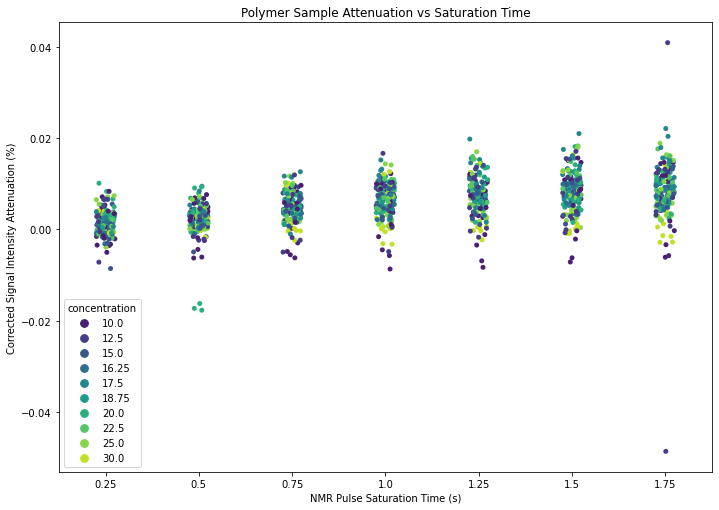

In [81]:
#Exploratory Data Analysis visualizations. 
#Below is concentration overlaid with attenuation and saturation time ---------

a4_dims = (11.7, 8.27)
fig1, ax = pyplot.subplots(figsize = a4_dims)
sns.stripplot(ax = ax, x = 'sat_time', y = 'corr_%_attenuation', data = corr_p_attenuation_df, hue = 'concentration', palette = 'viridis')

plt.title("Polymer Sample Attenuation vs Saturation Time")
plt.ylabel("Corrected Signal Intensity Attenuation (%)")
plt.xlabel("NMR Pulse Saturation Time (s)")

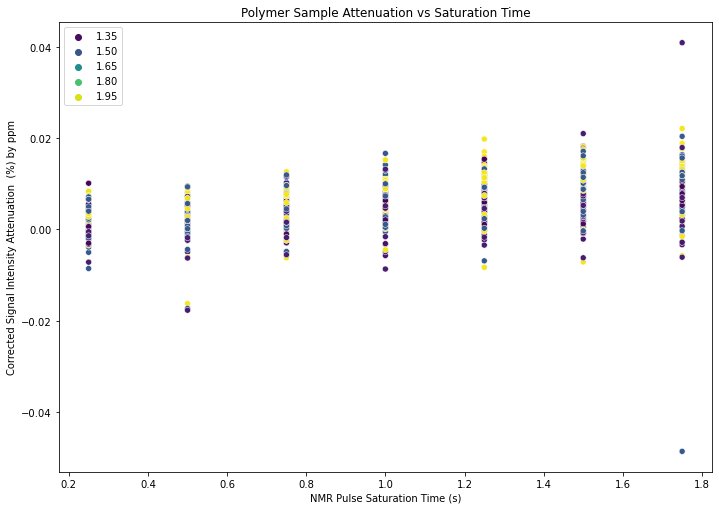

In [82]:
#bonus ---- visualizations, ppm overlaid with attenuation and saturation time

a4_dims = (11.7, 8.27)
fig2, ax2 = pyplot.subplots(figsize = a4_dims)
sns.scatterplot(ax = ax2, x = 'sat_time', y = 'corr_%_attenuation', data = corr_p_attenuation_df, hue ='ppm', palette = 'viridis', y_jitter = True, legend = 'brief')

# a stripplot looks nicer, but its legend is unneccessarily long with each individual ppm, need to use rounded ppm to use the below line
# sns.stripplot(ax = ax2, x = 'sat_time', y = 'corr_%_attenuation', data = corr_p_attenuation_df, hue ='ppm', palette = 'viridis', dodge = True)

plt.title("Polymer Sample Attenuation vs Saturation Time")
plt.ylabel("Corrected Signal Intensity Attenuation  (%) by ppm")
plt.xlabel("NMR Pulse Saturation Time (s)")
ax2.legend() 


In [83]:
##UNCOMMENT IF WANT TO SANITY CHECK WITH JEFF'S CODE USING FIGURES FROM THE PAA DATASET --------------------------------------------
##PAA CODE SANITY CHECKING CODE VALIDATION - Recreating Fig 182 from PAA 
# subset_ppm = corr_p_attenuation_df.loc[(corr_p_attenuation_df['replicate'] == 6) & (corr_p_attenuation_df['concentration'] == 10.0)]
# new_df = pd.DataFrame(subset_ppm)
# new_df['rounded_ppm'] = subset_ppm[['ppm']].astype(float).round(2)

# a4_dims = (11.7, 8.27)
# fig1, ax = pyplot.subplots(figsize = a4_dims)
# sns.scatterplot(ax = ax, x = 'sat_time', y = 'corr_%_attenuation', data = new_df, hue = 'rounded_ppm', palette = 'viridis')

# plt.title("Polymer Sample Attenuation vs Saturation Time")
# plt.ylabel("Corrected Signal Intensity Attenuation (%)")
# plt.xlabel("NMR Pulse Saturation Time (s)")
# plt.ylim(-0.025, 0.03)

In [84]:
##UNCOMMENT IF WANT TO SANITY CHECK WITH JEFF'S CODE USING FIGURES FROM THE PAA DATASET --------------------------------------------
##PAA CODE SANITY CHECKING CODE VALIDATION - Recreating Fig 132 from PAA 
# subset_ppm = corr_p_attenuation_df.loc[(corr_p_attenuation_df['replicate'] == 5) & (corr_p_attenuation_df['concentration'] == 20.0)]
# new_df = pd.DataFrame(subset_ppm)
# new_df['rounded_ppm'] = subset_ppm[['ppm']].astype(float).round(2)

# a4_dims = (11.7, 8.27)
# fig1, ax = pyplot.subplots(figsize = a4_dims)
# sns.scatterplot(ax = ax, x = 'sat_time', y = 'corr_%_attenuation', data = new_df, hue = 'rounded_ppm', palette = 'viridis')

# plt.title("Polymer Sample Attenuation vs Saturation Time")
# plt.ylabel("Corrected Signal Intensity Attenuation (%)")
# plt.xlabel("NMR Pulse Saturation Time (s)")
# plt.ylim(-0.025, 0.03)

In [85]:
## UNCOMMENT IF WANT TO SANITY CHECK WITH JEFF'S CODE USING FIGURES FROM THE PAA DATASET --------------------------------------------
## PAA CODE SANITY CHECKING CODE VALIDATION - Recreating Fig 128 from PAA 
# subset_ppm = corr_p_attenuation_df.loc[(corr_p_attenuation_df['replicate'] == 4) & (corr_p_attenuation_df['concentration'] == 15.0)]
# new_df = pd.DataFrame(subset_ppm)
# new_df['rounded_ppm'] = subset_ppm[['ppm']].astype(float).round(2)

# a4_dims = (11.7, 8.27)
# fig1, ax = pyplot.subplots(figsize = a4_dims)
# sns.scatterplot(ax = ax, x = 'sat_time', y = 'corr_%_attenuation', data = new_df, hue = 'rounded_ppm', palette = 'viridis')

# plt.title("Polymer Sample Attenuation vs Saturation Time")
# plt.ylabel("Corrected Signal Intensity Attenuation (%)")
# plt.xlabel("NMR Pulse Saturation Time (s)")
# plt.ylim(-0.025, 0.03)

In [86]:
## UNCOMMENT IF WANT TO SANITY CHECK WITH JEFF'S CODE USING FIGURES FROM THE PAA DATASET --------------------------------------------
## PAA CODE SANITY CHECKING VALIDATION - Recreating Fig 83 from PAA 
# subset_ppm = corr_p_attenuation_df.loc[(corr_p_attenuation_df['replicate'] == 3) & (corr_p_attenuation_df['concentration'] == 25.0)]
# new_df = pd.DataFrame(subset_ppm)
# new_df['rounded_ppm'] = subset_ppm[['ppm']].astype(float).round(2)

# a4_dims = (11.7, 8.27)
# fig1, ax = pyplot.subplots(figsize = a4_dims)
# sns.scatterplot(ax = ax, x = 'sat_time', y = 'corr_%_attenuation', data = new_df, hue = 'rounded_ppm', palette = 'viridis')

# plt.title("Polymer Sample Attenuation vs Saturation Time")
# plt.ylabel("Corrected Signal Intensity Attenuation (%)")
# plt.xlabel("NMR Pulse Saturation Time (s)")
# plt.ylim(-0.025, 0.03)

In [87]:
## UNCOMMENT IF WANT TO SANITY CHECK WITH JEFF'S CODE USING FIGURES FROM THE PAA DATASET --------------------------------------------
## PAA CODE SANITY CHECKING VALIDATION CODE VALIDATION - Recreating Fig 78 from PAA 
# subset_ppm = corr_p_attenuation_df.loc[(corr_p_attenuation_df['replicate'] == 2) & (corr_p_attenuation_df['concentration'] == 10.0)]
# new_df = pd.DataFrame(subset_ppm)
# new_df['rounded_ppm'] = subset_ppm[['ppm']].astype(float).round(2)

# a4_dims = (11.7, 8.27)
# fig1, ax = pyplot.subplots(figsize = a4_dims)
# sns.scatterplot(ax = ax, x = 'sat_time', y = 'corr_%_attenuation', data = new_df, hue = 'rounded_ppm', palette = 'viridis')

# plt.title("Polymer Sample Attenuation vs Saturation Time")
# plt.ylabel("Corrected Signal Intensity Attenuation (%)")
# plt.xlabel("NMR Pulse Saturation Time (s)")
# plt.ylim(-0.025, 0.03)

In [88]:
## UNCOMMENT IF WANT TO SANITY CHECK WITH JEFF'S CODE USING FIGURES FROM THE PAA DATASET --------------------------------------------
## PAA CODE SANITY CHECKING VALIDATION - Recreating Fig 47 from PAA 
# subset_ppm = corr_p_attenuation_df.loc[(corr_p_attenuation_df['replicate'] == 1) & (corr_p_attenuation_df['concentration'] == 18.75)]
# new_df = pd.DataFrame(subset_ppm)
# new_df['rounded_ppm'] = subset_ppm[['ppm']].astype(float).round(2)

# a4_dims = (11.7, 8.27)
# fig1, ax = pyplot.subplots(figsize = a4_dims)
# sns.scatterplot(ax = ax, x = 'sat_time', y = 'corr_%_attenuation', data = new_df, hue = 'rounded_ppm', palette = 'viridis')

# plt.title("Polymer Sample Attenuation vs Saturation Time")
# plt.ylabel("Corrected Signal Intensity Attenuation (%)")
# plt.xlabel("NMR Pulse Saturation Time (s)")
# plt.ylim(-0.025, 0.03)

<h1>Disco Data Processing Script</h1>
<h2>Part 2 Statistical Analysis</h2>

<p>Please ensure Part 1 has been run, and the data makes sense, before entering part 2.</p>

In [89]:
#PART 2 -------- Modelling the Data ---------------------------------------
# Visualize the dataframe before stat modelling section begins
corr_p_attenuation_df

,sample_or_control,replicate,title_string,concentration,sat_time,ppm,intensity,range,normalized,absolute,attenuation,corr_%_attenuation
1,sample,1,from 20190708 PAA Association 30um,30.0,0.25,1.9863,129.795,2.2029 .. 1.8477,2.8,108785,1064.17,-0.000286955
2,sample,1,from 20190708 PAA Association 30um,30.0,0.25,1.5215,76.2,1.6178 .. 1.4610,1.15,44704.6,463.339,-0.00104105
3,sample,1,from 20190708 PAA Association 30um,30.0,0.25,1.3678,94.334,1.4610 .. 1.0950,3.06,118934,1287.68,-0.000691601
1,sample,1,from 20200319-4-25umPAA,25.0,0.25,1.9861,104.043,2.2029 .. 1.8477,1.98,88020.3,1045.33,0.00235965
2,sample,1,from 20200319-4-25umPAA,25.0,0.25,1.52,61.2404,1.6178 .. 1.4610,0.84,37472.9,414.921,0.000315135
...,...,...,...,...,...,...,...,...,...,...,...,...
2,sample,6,from 20200831-2-12p5umPAABSM,12.5,1.75,1.5096,20.5263,1.6178 .. 1.4610,0.95,18048.3,1422.93,0.0125157
3,sample,6,from 20200831-2-12p5umPAABSM,12.5,1.75,1.3778,26.9289,1.4610 .. 1.0950,1.96,37231.6,2742.35,0.00697118
1,sample,6,from 20200831-2-10umPAABSM,10.0,1.75,1.9804,30.7398,2.2029 .. 1.8477,2.12,30472.5,2577.58,0.0117902
2,sample,6,from 20200831-2-10umPAABSM,10.0,1.75,1.5084,15.2217,1.6178 .. 1.4610,0.97,13977.2,1149.75,0.0117638


In [90]:
# now drop the rows that are entirely null from the dataframe shown above
corr_p_attenuation_df = corr_p_attenuation_df.dropna(how = "any")

# Display the dataframe again after the null rows have been dropped before stat modelling begins, note the difference in dimension from above
corr_p_attenuation_df

# Uncomment below if you want to see a table that describes the datatypes and quantity of each column
# corr_p_attenuation_df.info()

,sample_or_control,replicate,title_string,concentration,sat_time,ppm,intensity,range,normalized,absolute,attenuation,corr_%_attenuation
1,sample,1,from 20190708 PAA Association 30um,30.0,0.25,1.9863,129.795,2.2029 .. 1.8477,2.8,108785,1064.17,-0.000286955
2,sample,1,from 20190708 PAA Association 30um,30.0,0.25,1.5215,76.2,1.6178 .. 1.4610,1.15,44704.6,463.339,-0.00104105
3,sample,1,from 20190708 PAA Association 30um,30.0,0.25,1.3678,94.334,1.4610 .. 1.0950,3.06,118934,1287.68,-0.000691601
1,sample,1,from 20200319-4-25umPAA,25.0,0.25,1.9861,104.043,2.2029 .. 1.8477,1.98,88020.3,1045.33,0.00235965
2,sample,1,from 20200319-4-25umPAA,25.0,0.25,1.52,61.2404,1.6178 .. 1.4610,0.84,37472.9,414.921,0.000315135
...,...,...,...,...,...,...,...,...,...,...,...,...
2,sample,6,from 20200831-2-12p5umPAABSM,12.5,1.75,1.5096,20.5263,1.6178 .. 1.4610,0.95,18048.3,1422.93,0.0125157
3,sample,6,from 20200831-2-12p5umPAABSM,12.5,1.75,1.3778,26.9289,1.4610 .. 1.0950,1.96,37231.6,2742.35,0.00697118
1,sample,6,from 20200831-2-10umPAABSM,10.0,1.75,1.9804,30.7398,2.2029 .. 1.8477,2.12,30472.5,2577.58,0.0117902
2,sample,6,from 20200831-2-10umPAABSM,10.0,1.75,1.5084,15.2217,1.6178 .. 1.4610,0.97,13977.2,1149.75,0.0117638


In [91]:
# MORE SANITY CHECKING CODE ------------------------------------------------------------------------

# USE THE BELOW HARD CODED CODE IF YOU WANT TO SANITY CHECK HOW MANY OBSERVATIONS EACH REPLCATE HAS --------------- 
# rep1_df = corr_p_attenuation_df.loc[(corr_p_attenuation_df.replicate == 1), ['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time', 'ppm', 'absolute', 'attenuation', 'corr_%_attenuation']]
# rep2_df = corr_p_attenuation_df.loc[(corr_p_attenuation_df.replicate == 2), ['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time', 'ppm', 'absolute', 'attenuation', 'corr_%_attenuation']]
# rep3_df = corr_p_attenuation_df.loc[(corr_p_attenuation_df.replicate == 3), ['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time', 'ppm', 'absolute', 'attenuation', 'corr_%_attenuation']]
# rep4_df = corr_p_attenuation_df.loc[(corr_p_attenuation_df.replicate == 4), ['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time', 'ppm', 'absolute', 'attenuation', 'corr_%_attenuation']]
# rep5_df = corr_p_attenuation_df.loc[(corr_p_attenuation_df.replicate == 5), ['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time', 'ppm', 'absolute', 'attenuation', 'corr_%_attenuation']]
# rep6_df = corr_p_attenuation_df.loc[(corr_p_attenuation_df.replicate == 6), ['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time', 'ppm', 'absolute', 'attenuation', 'corr_%_attenuation']]
 

# compare_df = pd.DataFrame([],[]) 
# #count the non na cells
# compare_df['rep_1_count'] = rep1_df.count()
# compare_df['rep_2_count'] = rep2_df.count()
# compare_df['rep_3_count'] = rep3_df.count()
# compare_df['rep_4_count'] = rep4_df.count()
# compare_df['rep_5_count'] = rep5_df.count()
# compare_df['rep_6_count'] = rep6_df.count()

# compare_df
# ------------------------------------------------------------------------------------------------------

In [92]:
# now drop the column fields not required for stats modelling and further analysis
data_for_stats = corr_p_attenuation_df.drop(columns = ['title_string', 'sample_or_control', 'intensity', 'range', 'normalized', 'absolute', 'attenuation'])

# Add a new column to data for the index of proton peaks in an experimental set of a polymer (i.e. proton peak index applies to index protons within one polymer book)
proton_index = data_for_stats.index
data_for_stats['proton_peak_index'] = proton_index

#determine mean corr % attenuation and mean ppm per peak index, time, and concentration across replicates using groupby sum (reformat) and groupby mean (calculate mean)
regrouped_df = data_for_stats.groupby(by = ['concentration', 'sat_time', 'proton_peak_index', 'replicate'])[['ppm','corr_%_attenuation']].sum()
# regrouped_df = regrouped_df.reset_index()

#generate a table that includes the mean and std for ppm and corr_%_atten across the replicates, reset index
mean_corr_attenuation_ppm = regrouped_df.groupby(by = ['concentration', 'sat_time', 'proton_peak_index']).agg({'ppm': ['mean', 'std'], 'corr_%_attenuation': ['mean', 'std']})
# mean_corr_attenuation_ppm = mean_corr_attenuation_ppm.reset_index()

#display the new dataframe after columns dropped and aggregation operations performed, with a multi index
mean_corr_attenuation_ppm

ppm            \
                                              mean       std   
concentration sat_time proton_peak_index                       
10.0          0.25     1                  1.977983  0.004007   
                       2                  1.506100  0.003900   
                       3                  1.376533  0.004882   
              0.50     1                  1.977133  0.004425   
                       2                  1.505067  0.004059   
...                                            ...       ...   
30.0          1.50     2                  1.519225  0.000602   
                       3                  1.366200  0.002582   
              1.75     1                  1.982475  0.001825   
                       2                  1.519400  0.000920   
                       3                  1.366350  0.002493   

                                         corr_%_attenuation            
                                                       mean       std  
concentration sat_time proton_peak_index                               
10.0          0.25     1                           0.002928  0.004022  
                       2                           0.000205  0.004654  
                       3                           0.000732  0.003340  
              0.50     1                           0.002645  0.005291  
                       2                           0.001568  0.004293  
...                                                     ...       ...  
30.0          1.50     2                           0.005417  0.006682  
                       3                           0.002651  0.006690  
              1.75     1                           0.004714  0.007821  
                       2                           0.004492  0.007153  
                       3                           0.001975  0.006530  

[210 rows x 4 columns]

In [93]:
def get_dofs(peak_indices_array):
    
    ''' This function calculates the number of degrees of freedom (i.e. number of experimental replicates minus one) for statistical calculations 
    using the "indices array" of a given experimenal set as input.
    
    Input should be in the format: (in format: 11111 22222 3333 ... (specifically, it should be the proton_peak_index column from the "regrouped_df" above)
    where the count of each repeated digit minus one represents the degrees of freedom for that peak (i.e. the number of replicates -1).
    With zero based indexing, the function below generates the DOFs for the input array of proton_peak_index directly, in a format
    that can be directly appended to the stats table.
    '''

    dof_list = []
    dof_count = 0
    global_count = 0
    
    #loop through range of the peak indices array 
    for i in range(len(peak_indices_array)):
        global_count = global_count +1

        #if at the end of the global range, append final incremented dof count
        if global_count == len(peak_indices_array):
            dof_count = dof_count+1
            dof_list.append(dof_count)
            break

        #if current index is not equal to the value of the array at the next index, apply count of current index to DOF list, and reset DOF counter
        elif peak_indices_array[i] != peak_indices_array[i+1]:
            dof_list.append(dof_count)
            dof_count = 0

        #otherwise, increment DOF count and continue
        else:
            dof_count = dof_count + 1

    return dof_list    
    

In [94]:
#some old code: if reset_index() is uncommented above this works ----------------------------
# peak_index_array = peak_index_array = regrouped_df['proton_peak_index']
#-------------------------------------------------------------------------

#Calculate degrees of freedom and sample size for each datapoint using function above
peak_index_array = np.array(regrouped_df.index.get_level_values(2))
dofs = get_dofs(peak_index_array)

#append a new column with the calculated degrees of freedom to the table for each proton peak index
mean_corr_attenuation_ppm['dofs'] = dofs
mean_corr_attenuation_ppm['sample_size'] = np.asarray(dofs) + 1

#Display the new table with dofs and sample_size columns appended
mean_corr_attenuation_ppm

ppm            \
                                              mean       std   
concentration sat_time proton_peak_index                       
10.0          0.25     1                  1.977983  0.004007   
                       2                  1.506100  0.003900   
                       3                  1.376533  0.004882   
              0.50     1                  1.977133  0.004425   
                       2                  1.505067  0.004059   
...                                            ...       ...   
30.0          1.50     2                  1.519225  0.000602   
                       3                  1.366200  0.002582   
              1.75     1                  1.982475  0.001825   
                       2                  1.519400  0.000920   
                       3                  1.366350  0.002493   

                                         corr_%_attenuation           dofs  \
                                                       mean       std        
concentration sat_time proton_peak_index                                     
10.0          0.25     1                           0.002928  0.004022    5   
                       2                           0.000205  0.004654    5   
                       3                           0.000732  0.003340    5   
              0.50     1                           0.002645  0.005291    5   
                       2                           0.001568  0.004293    5   
...                                                     ...       ...  ...   
30.0          1.50     2                           0.005417  0.006682    3   
                       3                           0.002651  0.006690    3   
              1.75     1                           0.004714  0.007821    3   
                       2                           0.004492  0.007153    3   
                       3                           0.001975  0.006530    4   

                                         sample_size  
                                                      
concentration sat_time proton_peak_index              
10.0          0.25     1                           6  
                       2                           6  
                       3                           6  
              0.50     1                           6  
                       2                           6  
...                                              ...  
30.0          1.50     2                           4  
                       3                           4  
              1.75     1                           4  
                       2                           4  
                       3                           5  

[210 rows x 6 columns]

In [95]:
#now, we have all the required information in one table to test for statistical significance, via a one sample t-test against population distribution.

''' 
    Procedure followed from: https://machinelearningmastery.com/critical-values-for-statistical-hypothesis-testing/ 
    
    One sample t test: tests whether the mean of a population is significantly different than a sample mean.
    A proper t-test analysis performs calculations to help infer what the expected population mean (that 
    contains the sample) given just a sample mean. (Inferential statistics).
    
    Null Hypothesis: population mean = sample mean (avg corr % attenuation for a proton peak of N replicates at fixed experimental parameters)
    Alternative Hypothesis: population mean >= sample mean (avg corr % attenuation for a proton peak of N replicates at fixed experimental parameters)
    
    Population parameters used are that of the student's t distribution.
    Alpha = 0.1 for statistical significance. 
    
    Still theoretically need to validate sample data meets assumptions for one sample t test: normal dist, homegeneity of variance, & no outliers. **
    
'''

# Initialize Relevant t test Parameters
p = 0.90
dof = mean_corr_attenuation_ppm['dofs']
mean_t = mean_corr_attenuation_ppm['corr_%_attenuation']['mean'].abs()
std_t = mean_corr_attenuation_ppm['corr_%_attenuation']['std']
sample_size_t = mean_corr_attenuation_ppm['sample_size']

# retrieve value <= probability from t distribution, based on DOF for sample 
crit_t_value = t.ppf(p, dof)
# print(crit_t_value)

# confirm the p value with cdf, for sanity checking 
# p = t.cdf(crit_t_value, dof)
# print(p)

#perform one sample t-test for significance, significant if t_test_results < 0 
t_test_results =  mean_t - crit_t_value * (std_t/(np.sqrt(sample_size_t)))
mean_corr_attenuation_ppm['t_results'] = t_test_results
mean_corr_attenuation_ppm['significance'] = mean_corr_attenuation_ppm['t_results'] > 0

#Visualize dataframe with new statistics columns appended
mean_corr_attenuation_ppm

ppm            \
                                              mean       std   
concentration sat_time proton_peak_index                       
10.0          0.25     1                  1.977983  0.004007   
                       2                  1.506100  0.003900   
                       3                  1.376533  0.004882   
              0.50     1                  1.977133  0.004425   
                       2                  1.505067  0.004059   
...                                            ...       ...   
30.0          1.50     2                  1.519225  0.000602   
                       3                  1.366200  0.002582   
              1.75     1                  1.982475  0.001825   
                       2                  1.519400  0.000920   
                       3                  1.366350  0.002493   

                                         corr_%_attenuation           dofs  \
                                                       mean       std        
concentration sat_time proton_peak_index                                     
10.0          0.25     1                           0.002928  0.004022    5   
                       2                           0.000205  0.004654    5   
                       3                           0.000732  0.003340    5   
              0.50     1                           0.002645  0.005291    5   
                       2                           0.001568  0.004293    5   
...                                                     ...       ...  ...   
30.0          1.50     2                           0.005417  0.006682    3   
                       3                           0.002651  0.006690    3   
              1.75     1                           0.004714  0.007821    3   
                       2                           0.004492  0.007153    3   
                       3                           0.001975  0.006530    4   

                                         sample_size t_results significance  
                                                                             
concentration sat_time proton_peak_index                                     
10.0          0.25     1                           6  0.000505         True  
                       2                           6 -0.002600        False  
                       3                           6 -0.001280        False  
              0.50     1                           6 -0.000543        False  
                       2                           6 -0.001018        False  
...                                              ...       ...          ...  
30.0          1.50     2                           4 -0.000055        False  
                       3                           4 -0.002828        False  
              1.75     1                           4 -0.001691        False  
                       2                           4 -0.001366        False  
                       3                           5 -0.002503        False  

[210 rows x 8 columns]

In [96]:
#For each concentration, compute the amplification factor AFconc = Cj/10. 

#Note: We can adjust amp factor denominator as required based on experimental input for a given polymer. For PAA it is 10.
amp_factor_denominator = 10
amp_factor = np.array(mean_corr_attenuation_ppm.index.get_level_values(0))/amp_factor_denominator
mean_corr_attenuation_ppm['amp_factor'] = amp_factor

#Calculate the amplification factor for the data_for_stats ungrouped table as well (i.e. per replicate data table)
data_for_stats['amp_factor'] = np.array(data_for_stats[['concentration']])/amp_factor_denominator

#display the mean data table with the amp_factor added
mean_corr_attenuation_ppm

ppm            \
                                              mean       std   
concentration sat_time proton_peak_index                       
10.0          0.25     1                  1.977983  0.004007   
                       2                  1.506100  0.003900   
                       3                  1.376533  0.004882   
              0.50     1                  1.977133  0.004425   
                       2                  1.505067  0.004059   
...                                            ...       ...   
30.0          1.50     2                  1.519225  0.000602   
                       3                  1.366200  0.002582   
              1.75     1                  1.982475  0.001825   
                       2                  1.519400  0.000920   
                       3                  1.366350  0.002493   

                                         corr_%_attenuation           dofs  \
                                                       mean       std        
concentration sat_time proton_peak_index                                     
10.0          0.25     1                           0.002928  0.004022    5   
                       2                           0.000205  0.004654    5   
                       3                           0.000732  0.003340    5   
              0.50     1                           0.002645  0.005291    5   
                       2                           0.001568  0.004293    5   
...                                                     ...       ...  ...   
30.0          1.50     2                           0.005417  0.006682    3   
                       3                           0.002651  0.006690    3   
              1.75     1                           0.004714  0.007821    3   
                       2                           0.004492  0.007153    3   
                       3                           0.001975  0.006530    4   

                                         sample_size t_results significance  \
                                                                              
concentration sat_time proton_peak_index                                      
10.0          0.25     1                           6  0.000505         True   
                       2                           6 -0.002600        False   
                       3                           6 -0.001280        False   
              0.50     1                           6 -0.000543        False   
                       2                           6 -0.001018        False   
...                                              ...       ...          ...   
30.0          1.50     2                           4 -0.000055        False   
                       3                           4 -0.002828        False   
              1.75     1                           4 -0.001691        False   
                       2                           4 -0.001366        False   
                       3                           5 -0.002503        False   

                                         amp_factor  
                                                     
concentration sat_time proton_peak_index             
10.0          0.25     1                        1.0  
                       2                        1.0  
                       3                        1.0  
              0.50     1                        1.0  
                       2                        1.0  
...                                             ...  
30.0          1.50     2                        3.0  
                       3                        3.0  
              1.75     1                        3.0  
                       2                        3.0  
                       3                        3.0  

[210 rows x 9 columns]

In [97]:
#Display the per-replicate data table (the table before grouping for statisitcal analysis) with the amp_factor added:
data_for_stats

,replicate,concentration,sat_time,ppm,corr_%_attenuation,proton_peak_index,amp_factor
1,1,30.0,0.25,1.9863,-0.000286955,1,3.00
2,1,30.0,0.25,1.5215,-0.00104105,2,3.00
3,1,30.0,0.25,1.3678,-0.000691601,3,3.00
1,1,25.0,0.25,1.9861,0.00235965,1,2.50
2,1,25.0,0.25,1.52,0.000315135,2,2.50
...,...,...,...,...,...,...,...
2,6,12.5,1.75,1.5096,0.0125157,2,1.25
3,6,12.5,1.75,1.3778,0.00697118,3,1.25
1,6,10.0,1.75,1.9804,0.0117902,1,1.00
2,6,10.0,1.75,1.5084,0.0117638,2,1.00


In [98]:
#identify non-statistically significant peaks to be removed from comparison for both mean and per replicate dataframes, and drop them from the dataframes

'''
Criterion for Dropping Peaks from Further Consideration: If more than two proton peak datapoints are flagged as not significant in the mean dataframe 
WITHIN a given concentration, the associated proton peak is removed from further analysis.

'''

#initialize a new mean df based on the old mean df that will contain only data that meet the criterion above for further analysis
significant_corr_attenuation = mean_corr_attenuation_ppm

#The below code checks data for the criterion and then removes rows if they do not pass --------

# define an indexer shortcut for pandas multi-index dataframes, such as the present mean dataframe
idx = pd.IndexSlice

# Assign unique protons to a list to use for subsetting the df via multi-index and the multi-index slicing method
unique_protons = np.asarray(proton_index.unique()).tolist()
unique_concentrations = data_for_stats.concentration.unique().tolist()

#initialize list to contain the points to remove
pts_to_remove = []

for p in unique_protons:
    for c in unique_concentrations:
        
        #subset the df via index slice based on the current peak and concentration
        current_subset_df = significant_corr_attenuation.loc[idx[c, :, p]]
        
        #subset further for where significance is false
        subset_insignificant = current_subset_df.loc[(current_subset_df['significance'] == False)]
        
        #if there's more than 2 datapoints where significance is False within the subset, drop p's proton peaks for c's concentration from the significant_corr_attenuation df
        if len(subset_insignificant) > 2:
            
            pts_to_remove.append(current_subset_df.index)
            significant_corr_attenuation = significant_corr_attenuation.drop(current_subset_df.index, inplace = False)  

print('Removed insignificant points are:', pts_to_remove)
#create and print dropped points to a summary file
dropped_points_file = open("{}/dropped_insignificant_points.txt".format(output_directory), "w")
dropped_points_file.write("The datapoints dropped from consideration due to not meeting the criteria for significance are: \n{}".format(pts_to_remove))
dropped_points_file.close()

Removed insignificant points are: [MultiIndex([(30.0, 0.25, 1),
            (30.0,  0.5, 1),
            (30.0, 0.75, 1),
            (30.0,  1.0, 1),
            (30.0, 1.25, 1),
            (30.0,  1.5, 1),
            (30.0, 1.75, 1)],
           names=['concentration', 'sat_time', 'proton_peak_index']), MultiIndex([(30.0, 0.25, 2),
            (30.0,  0.5, 2),
            (30.0, 0.75, 2),
            (30.0,  1.0, 2),
            (30.0, 1.25, 2),
            (30.0,  1.5, 2),
            (30.0, 1.75, 2)],
           names=['concentration', 'sat_time', 'proton_peak_index']), MultiIndex([(30.0, 0.25, 3),
            (30.0,  0.5, 3),
            (30.0, 0.75, 3),
            (30.0,  1.0, 3),
            (30.0, 1.25, 3),
            (30.0,  1.5, 3),
            (30.0, 1.75, 3)],
           names=['concentration', 'sat_time', 'proton_peak_index']), MultiIndex([(10.0, 0.25, 3),
            (10.0,  0.5, 3),
            (10.0, 0.75, 3),
            (10.0,  1.0, 3),
            (10.0, 1.25, 3)

In [99]:
#Remove the corresponding points from the per-replicate data that failed the acceptance criterion  ------------------------------------------------

# Reset index and drop the old index column, just getting the dataframe ready for this
data_for_stats = data_for_stats.reset_index()
data_for_stats = data_for_stats.drop('index', axis = 1)

# Now need to remove the points we already dropped from significant_corr_attenuation from data_for_stats
for num_pts in pts_to_remove:
    for exp_parameters in num_pts:
        
        drop_subset = (data_for_stats.loc[(data_for_stats['concentration'] == exp_parameters[0]) & (data_for_stats['sat_time'] == exp_parameters[1]) & (data_for_stats['proton_peak_index'] == exp_parameters[2])])
        data_for_stats = data_for_stats.drop(drop_subset.index)

#Reassign data_for_stats (the data on an individual replicate basis) to a new variable called stats_df_replicates, and assign the previously aggregated dataframe to a new variable called stats_df_mean
stats_df_replicates = data_for_stats.reset_index()
stats_df_mean = significant_corr_attenuation

In [100]:
#View the Mean Stats Dataframe after points dropped, before curve fitting
stats_df_mean

ppm            \
                                              mean       std   
concentration sat_time proton_peak_index                       
10.0          0.25     1                  1.977983  0.004007   
                       2                  1.506100  0.003900   
              0.50     1                  1.977133  0.004425   
                       2                  1.505067  0.004059   
              0.75     1                  1.977217  0.004574   
...                                            ...       ...   
25.0          1.50     2                  1.518533  0.002383   
                       3                  1.357017  0.022126   
              1.75     1                  1.984950  0.003391   
                       2                  1.518683  0.002240   
                       3                  1.357217  0.022000   

                                         corr_%_attenuation           dofs  \
                                                       mean       std        
concentration sat_time proton_peak_index                                     
10.0          0.25     1                           0.002928  0.004022    5   
                       2                           0.000205  0.004654    5   
              0.50     1                           0.002645  0.005291    5   
                       2                           0.001568  0.004293    5   
              0.75     1                           0.005010  0.005951    5   
...                                                     ...       ...  ...   
25.0          1.50     2                           0.007013  0.005891    5   
                       3                           0.005749  0.006356    5   
              1.75     1                           0.009209  0.005945    5   
                       2                           0.006661  0.005154    5   
                       3                           0.006419  0.005334    5   

                                         sample_size t_results significance  \
                                                                              
concentration sat_time proton_peak_index                                      
10.0          0.25     1                           6  0.000505         True   
                       2                           6 -0.002600        False   
              0.50     1                           6 -0.000543        False   
                       2                           6 -0.001018        False   
              0.75     1                           6  0.001424         True   
...                                              ...       ...          ...   
25.0          1.50     2                           6  0.003464         True   
                       3                           6  0.001920         True   
              1.75     1                           6  0.005628         True   
                       2                           6  0.003556         True   
                       3                           6  0.003205         True   

                                         amp_factor  
                                                     
concentration sat_time proton_peak_index             
10.0          0.25     1                        1.0  
                       2                        1.0  
              0.50     1                        1.0  
                       2                        1.0  
              0.75     1                        1.0  
...                                             ...  
25.0          1.50     2                        2.5  
                       3                        2.5  
              1.75     1                        2.5  
                       2                        2.5  
                       3                        2.5  

[182 rows x 9 columns]

In [101]:
#View the Per Replicate Stats DataFrame after points dropped, before curve fitting
stats_df_replicates

,index,replicate,concentration,sat_time,ppm,corr_%_attenuation,proton_peak_index,amp_factor
0,3,1,25.0,0.25,1.9861,0.00235965,1,2.50
1,4,1,25.0,0.25,1.52,0.000315135,2,2.50
2,5,1,25.0,0.25,1.3688,0.00143222,3,2.50
3,6,1,22.5,0.25,1.986,0.00096333,1,2.25
4,7,1,22.5,0.25,1.52,0.000215282,2,2.25
...,...,...,...,...,...,...,...,...
1024,1149,6,12.5,1.75,1.9816,0.0131615,1,1.25
1025,1150,6,12.5,1.75,1.5096,0.0125157,2,1.25
1026,1151,6,12.5,1.75,1.3778,0.00697118,3,1.25
1027,1152,6,10.0,1.75,1.9804,0.0117902,1,1.00


In [102]:
'''
Now we are ready to calculate the nonlinear curve fit models ("hat" models), for both the individual replicates (via stats_df_replicates), and on an mean (or "bar") basis (stats_df_mean).
Mean, average, and bar are used equivalently in this part of the code, sorry for any confusion.

ikj sub-scripts are used in this script to keep track of the fixed experimental variables pertinent to this analysis. 
    For clarity:
     i = NMR saturation time (sat_time) column
     k = Sample proton peak index (proton_peak_index) column
     j = Sample concentration (concentration) column
 
    yikj = response model (Amp Factor x Corr % Attenuation) on a per replicate basis (not mean), fits with stats_df_replicates
    yikj_bar = response model (Amp Factor x Corr % Attenuation) on an average basis, fits with stats_df_mean
    yikj_hat = the fitted nonlinear model according to the levenburg marquadt minimization of least squares algorithm
'''
#assign yijk to the replicate dataframe 
stats_df_replicates['yikj'] = stats_df_replicates[['corr_%_attenuation']].values*(stats_df_replicates[['amp_factor']].values)

#assign yijk_bar to the mean dataframe
stats_df_mean['yikj_bar'] = (stats_df_mean['corr_%_attenuation']['mean'])*(stats_df_mean['amp_factor'])

#define a subset of the mean dataframe such that ONLY statistically significant datapoints are used for curve fitting purposes
# stats_df_mean_curvefit_subset = stats_df_mean.loc[stats_df_mean['significance'] == True]


In [105]:
#Define Function to be Curve Fit 
def y_hat_fit(t, a, b):
    '''
    This function returns y_ikj_hat as the fit model based on alpha and beta.
    
    Some useful scipy example references for curve fitting:
    1) https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares
    2) https://lmfit.github.io/lmfit-py/model.html
    3) https://astrofrog.github.io/py4sci/_static/15.%20Fitting%20models%20to%20data.html 

    '''
    return a * (1 - np.exp(t * -b))

Exporting all mean and individual curve fit figures to an output directory... this may take a moment.


<ipython-input-106-c1e42e14a564>:131: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2, (ax2) = plt.subplots(1, figsize = (8, 4))


Export of all figures to file complete!


<ipython-input-106-c1e42e14a564>:46: RuntimeWarning: Mean of empty slice.
  ppm_bar = one_graph_data_mean['ppm']['mean'].values.mean().astype(float).round(4)
/Users/s.stuart/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


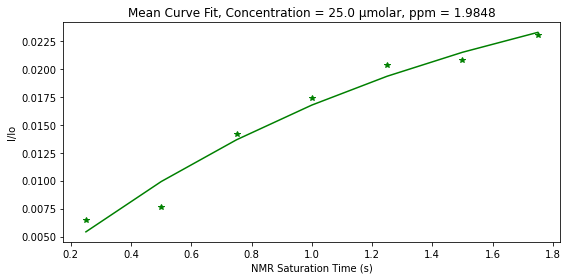

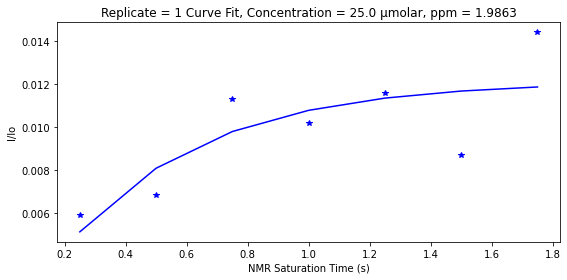

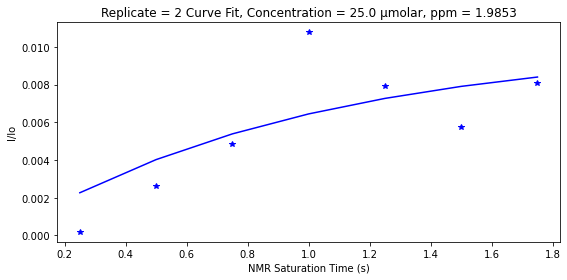

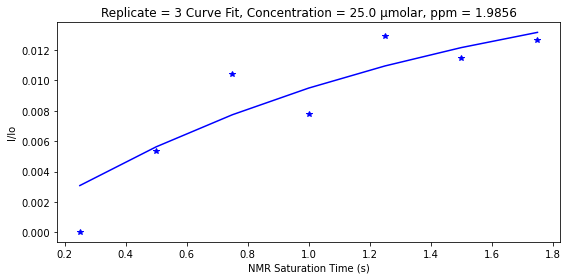

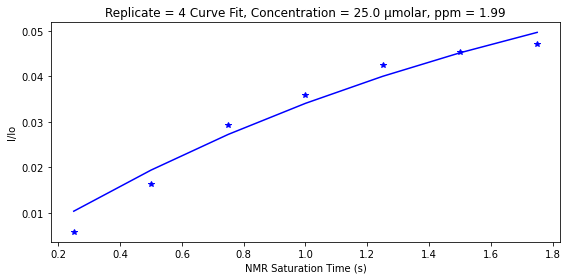

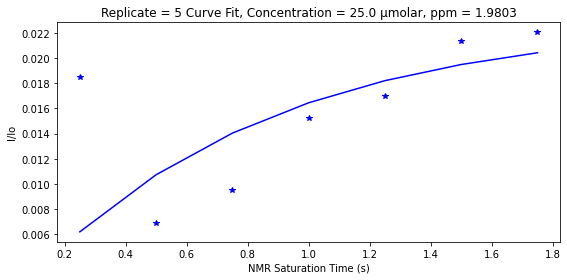

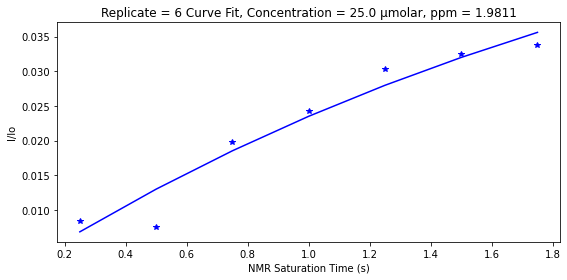

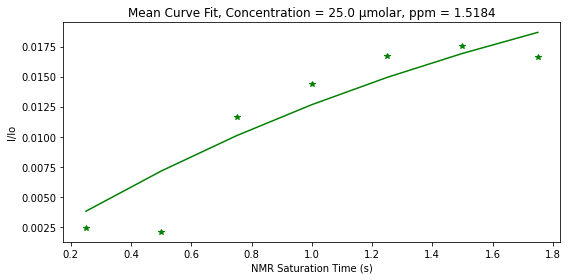

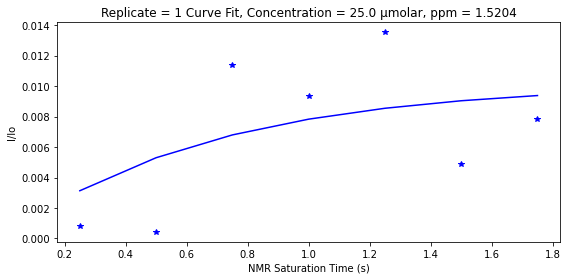

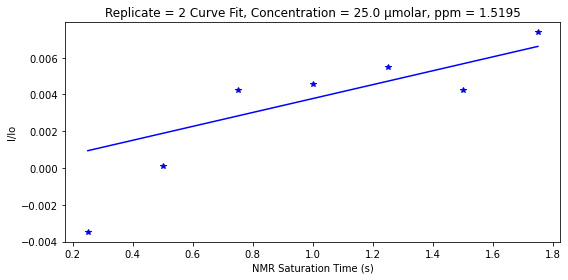

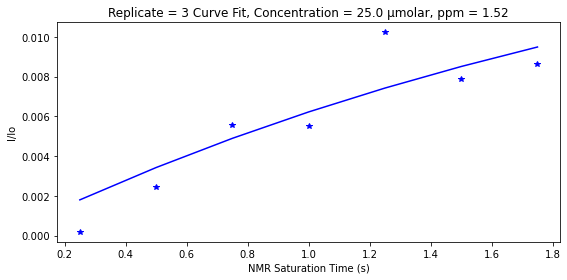

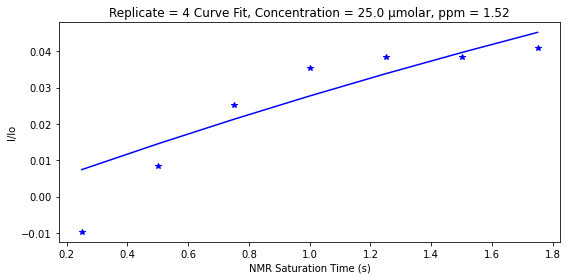

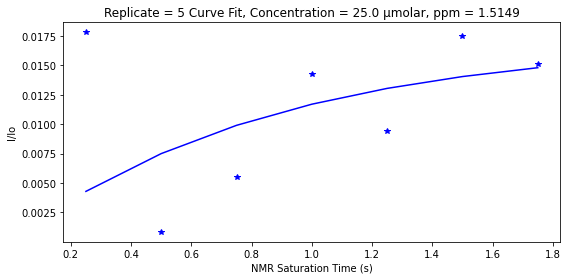

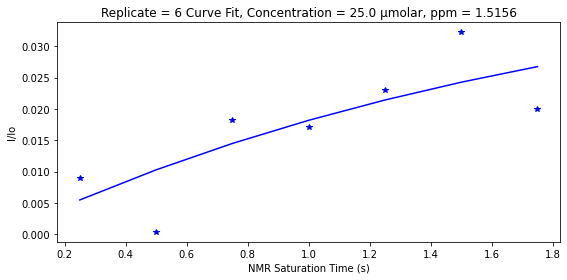

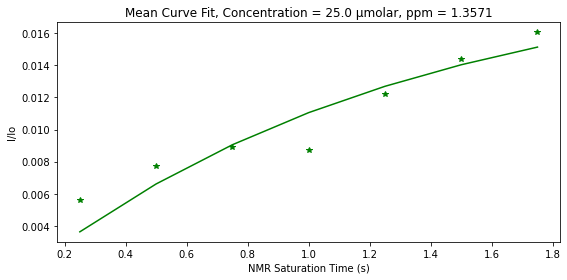

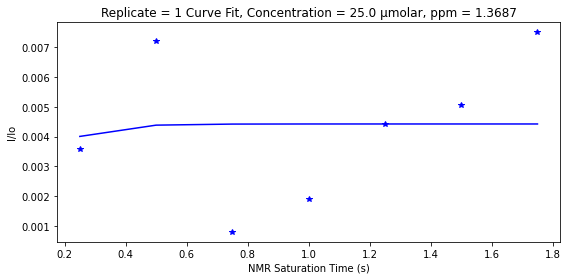

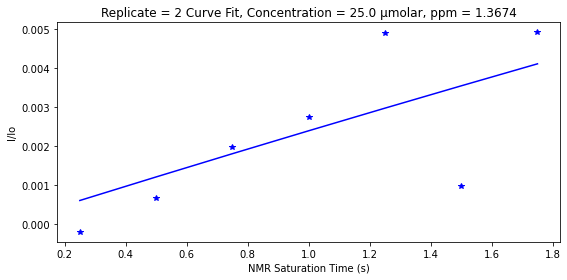

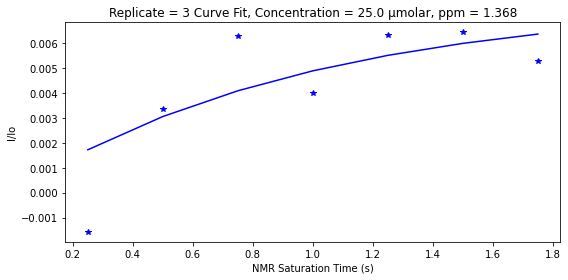

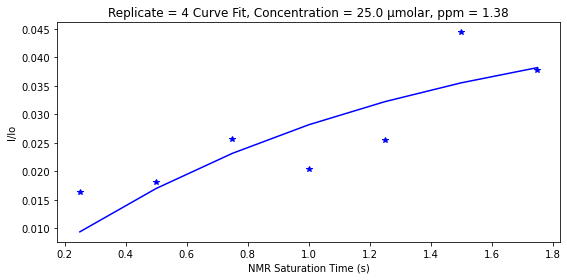

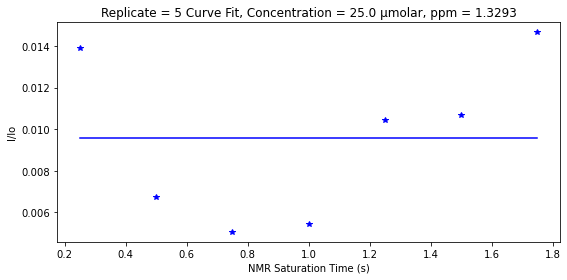

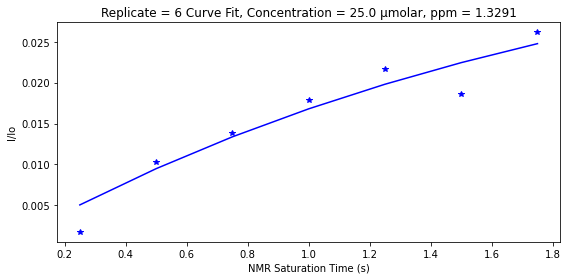

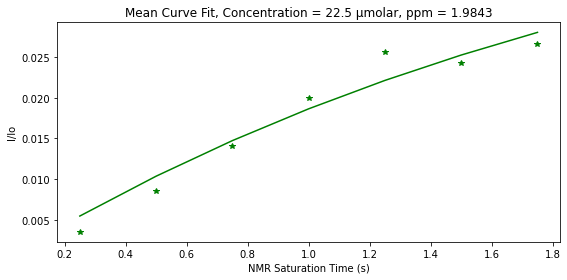

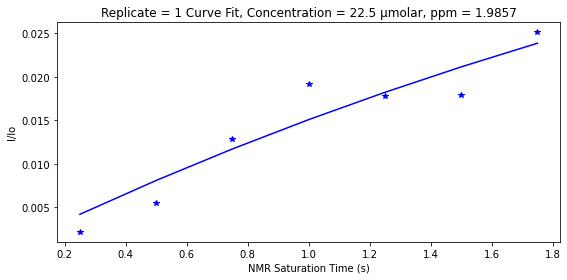

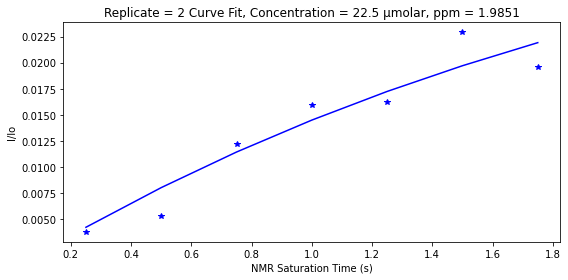

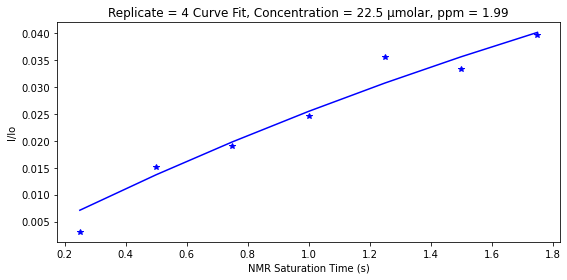

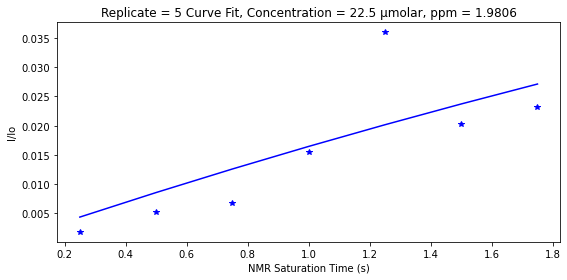

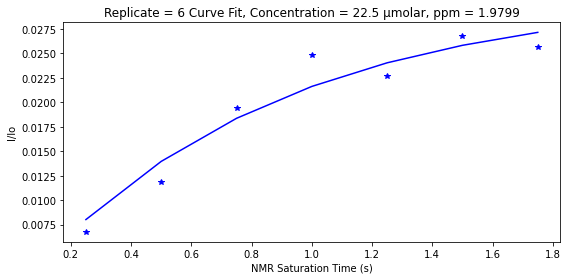

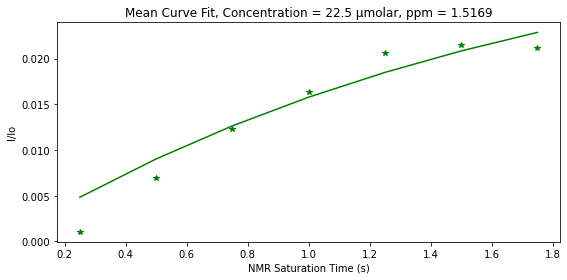

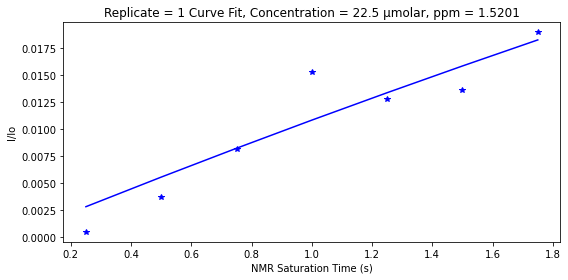

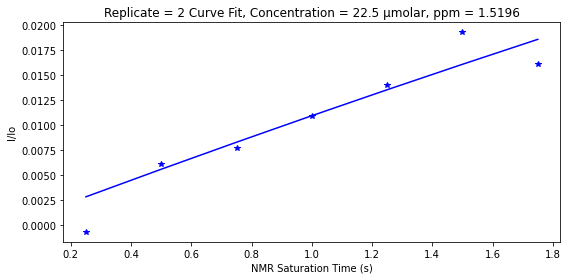

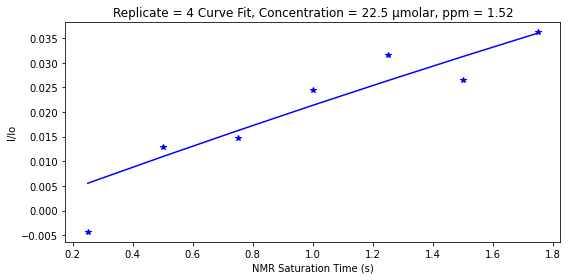

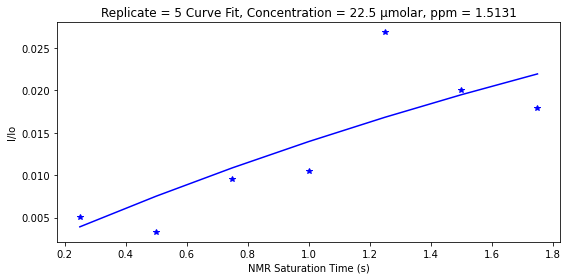

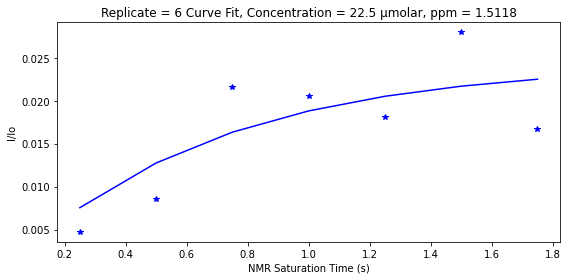

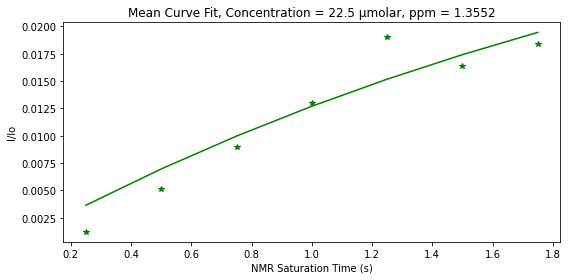

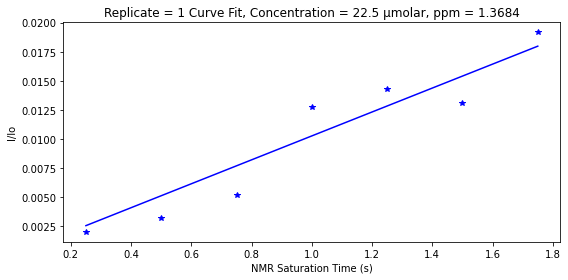

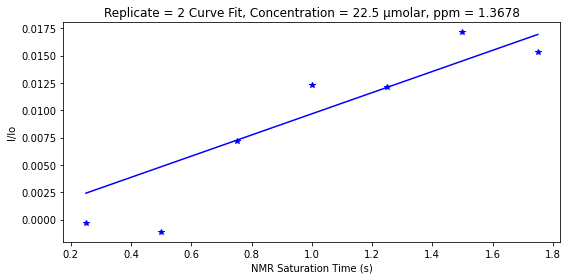

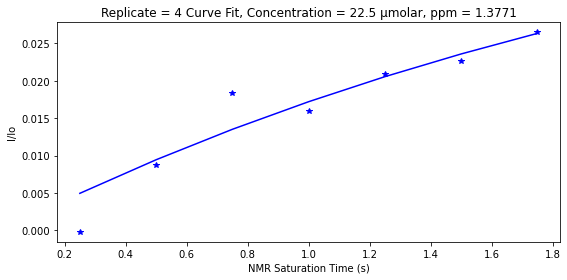

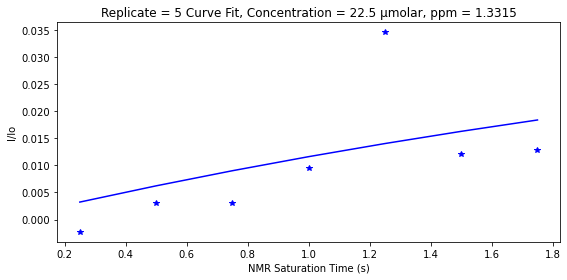

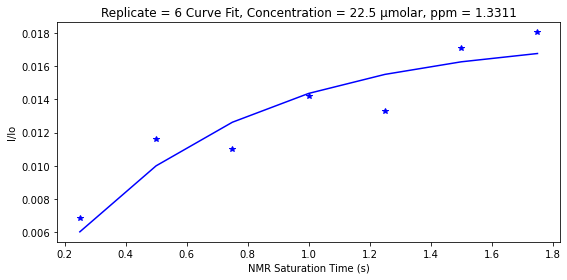

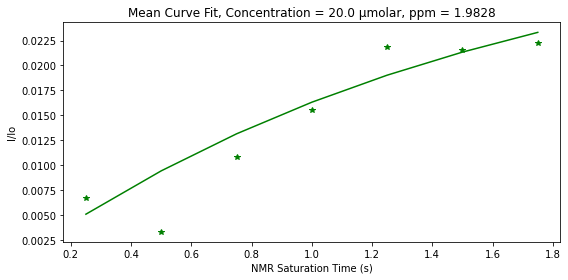

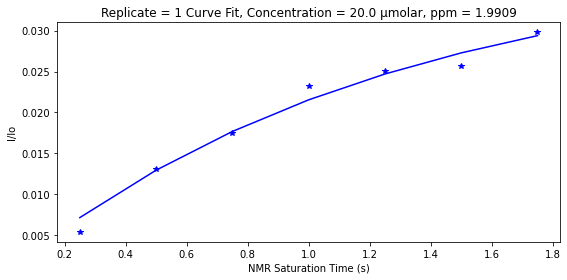

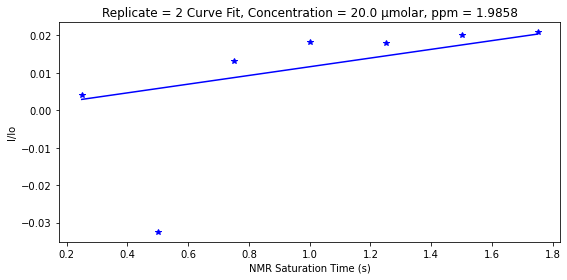

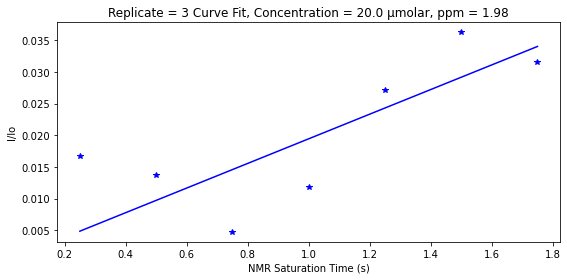

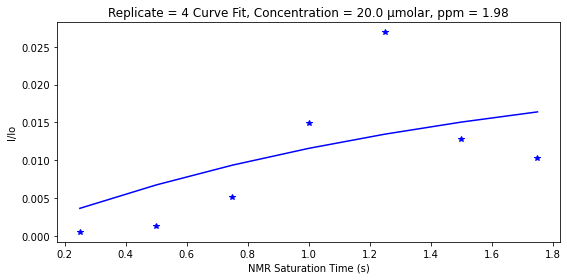

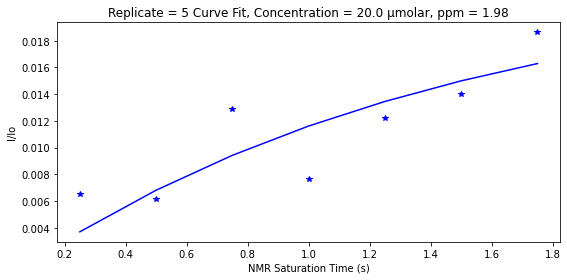

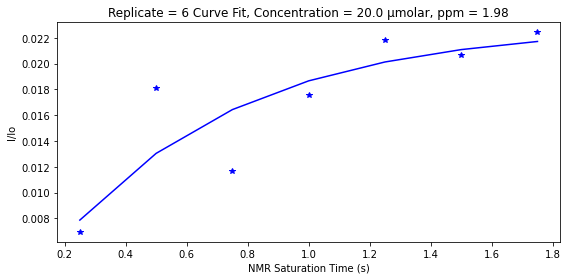

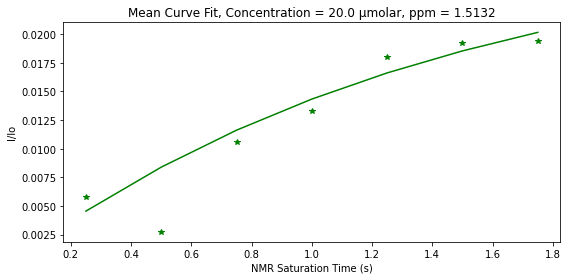

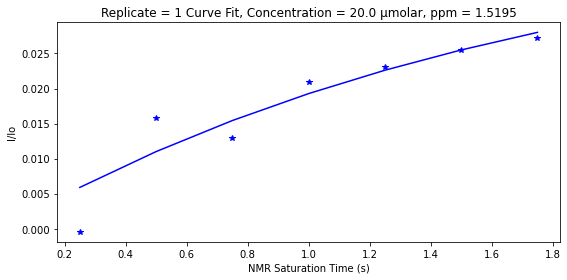

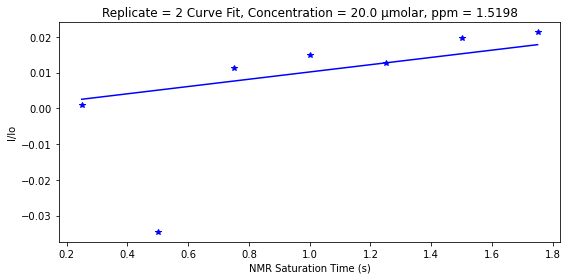

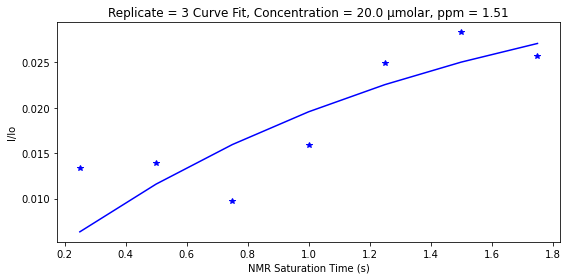

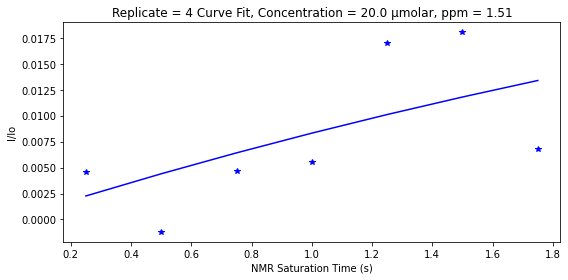

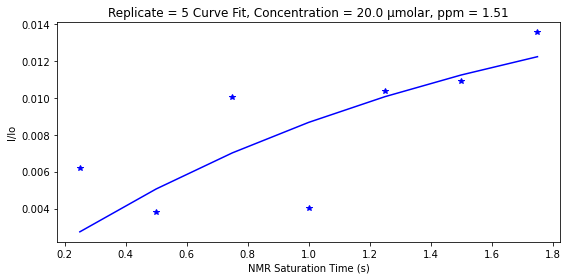

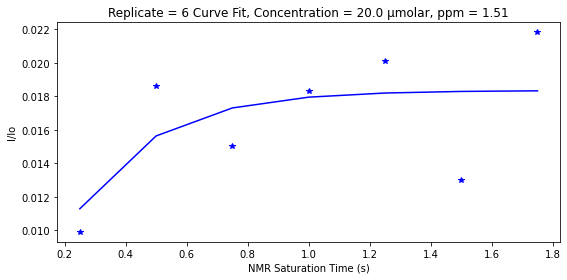

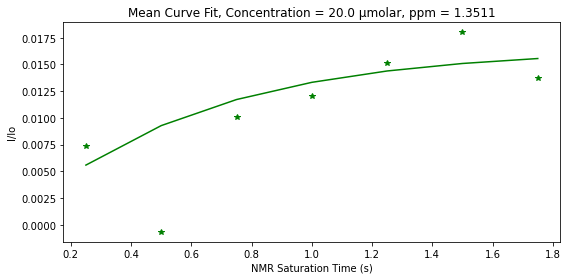

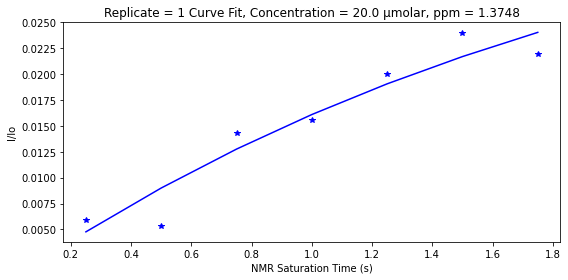

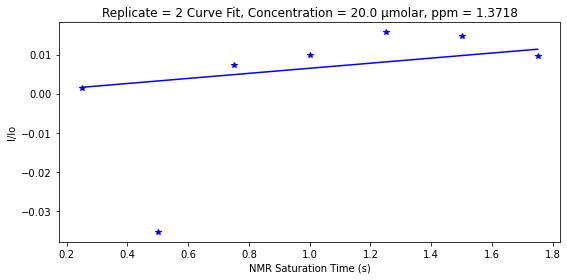

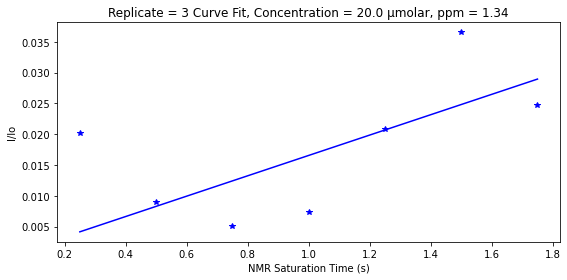

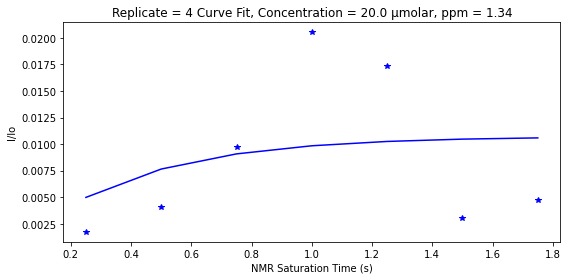

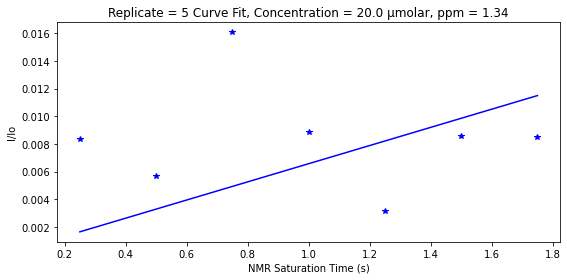

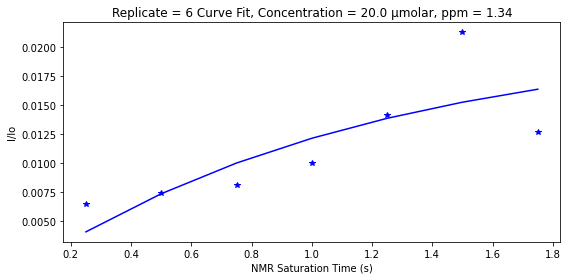

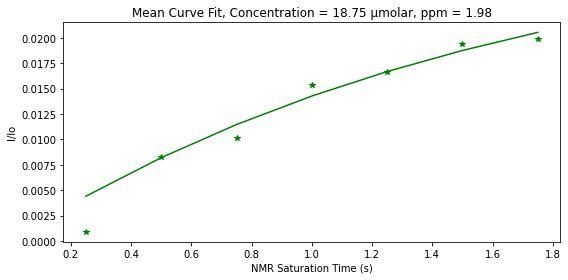

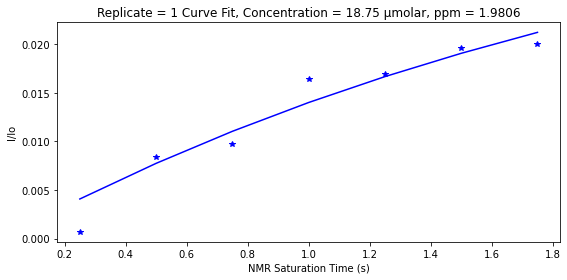

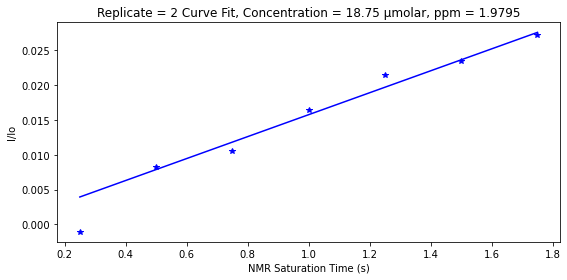

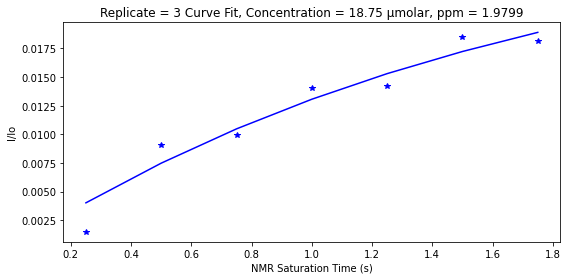

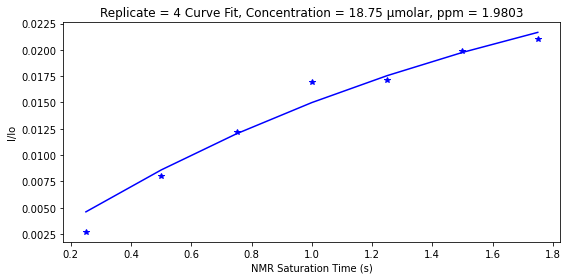

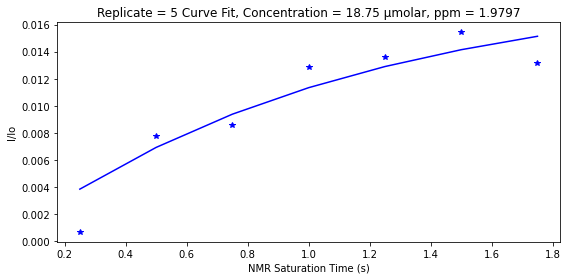

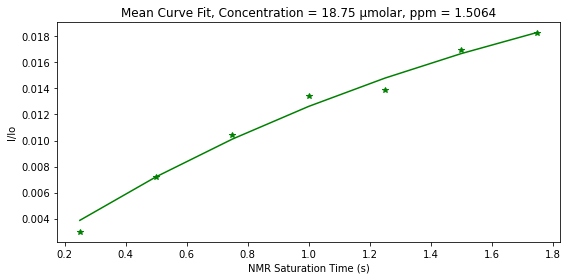

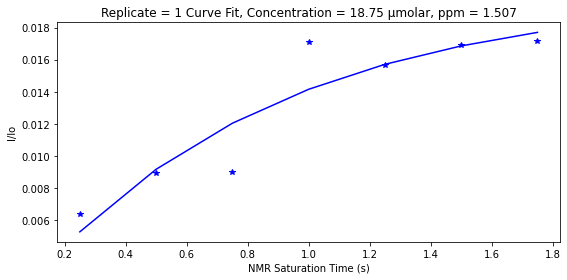

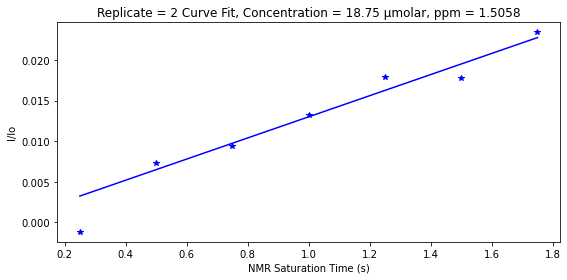

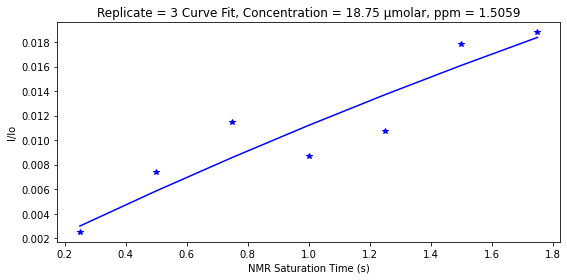

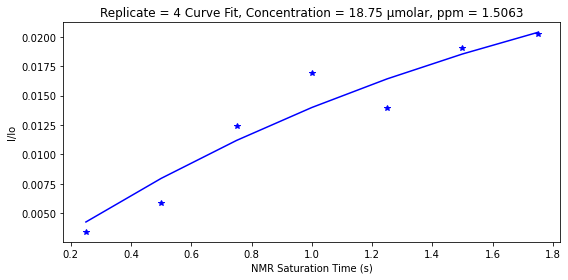

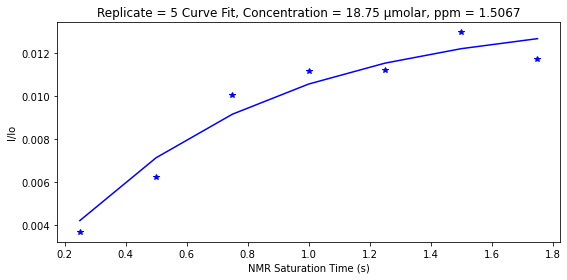

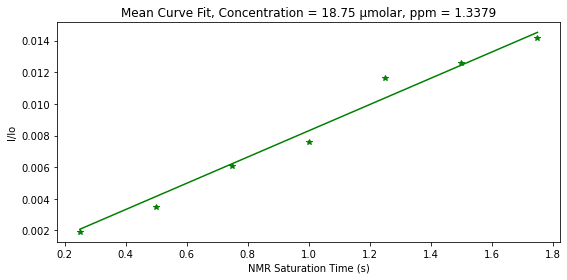

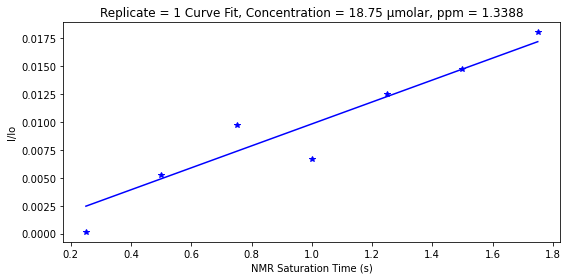

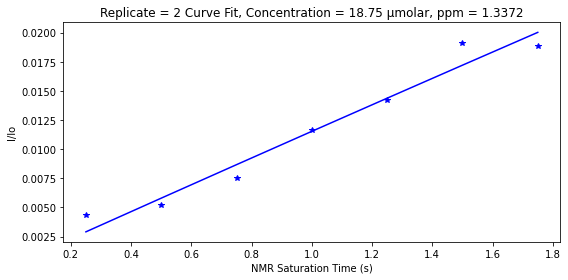

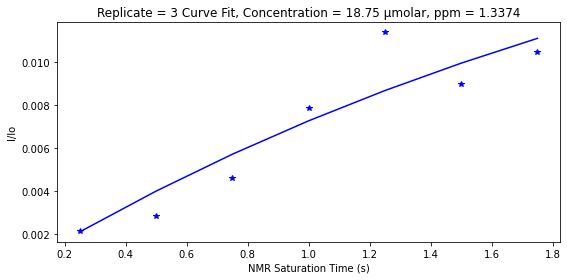

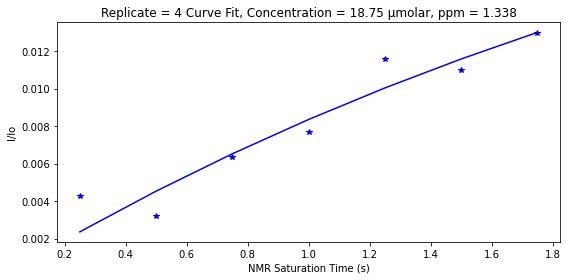

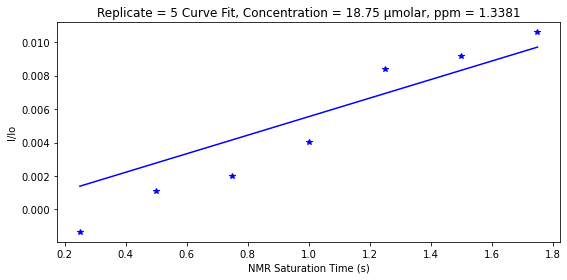

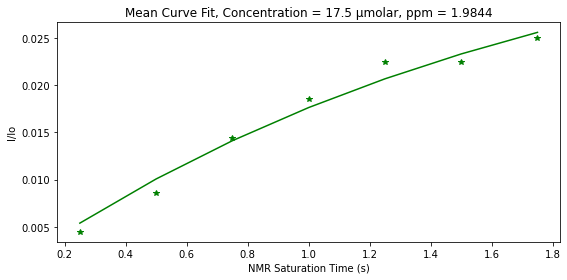

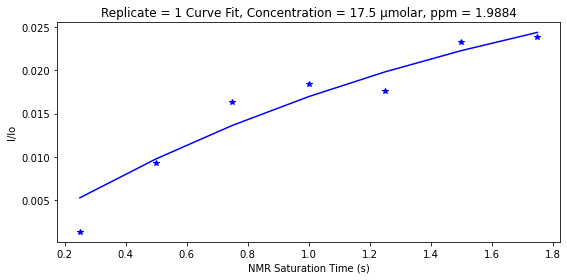

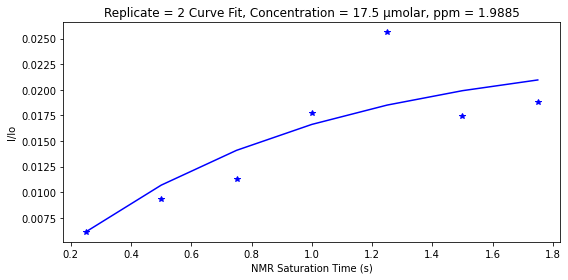

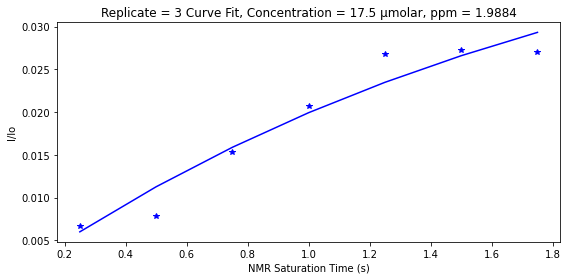

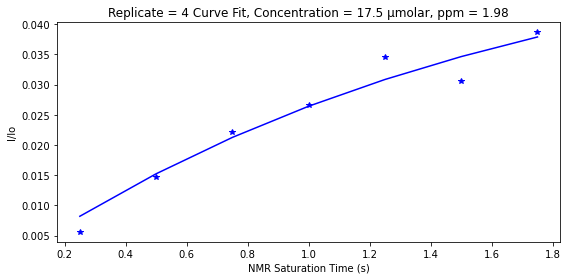

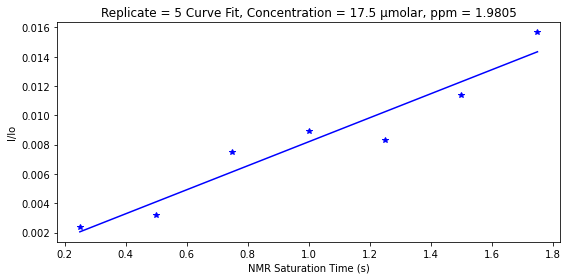

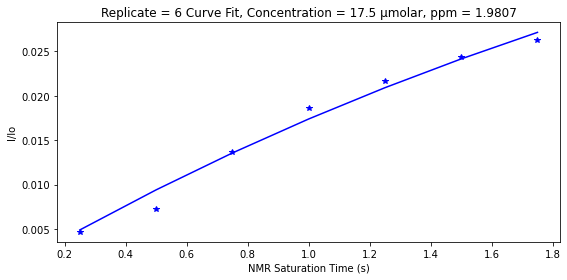

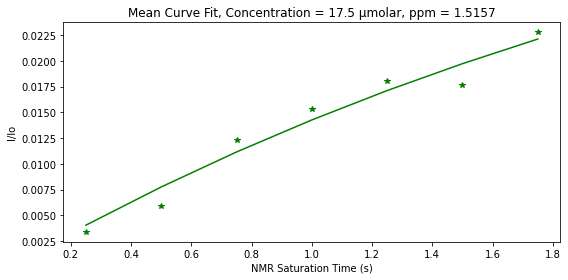

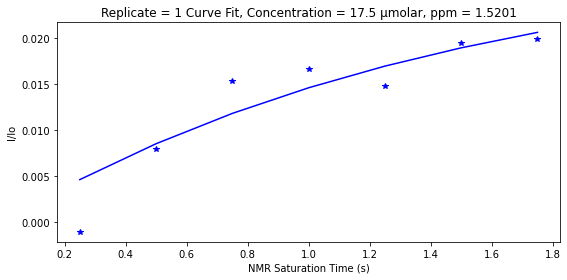

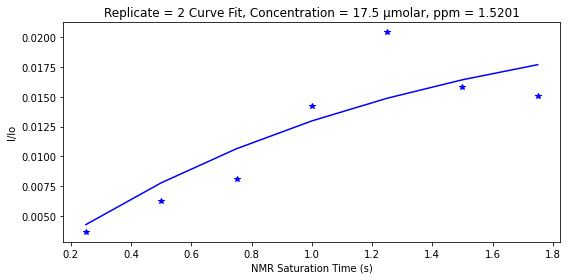

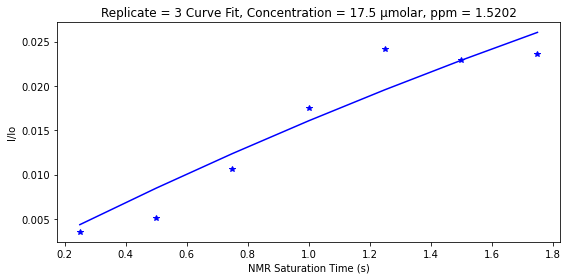

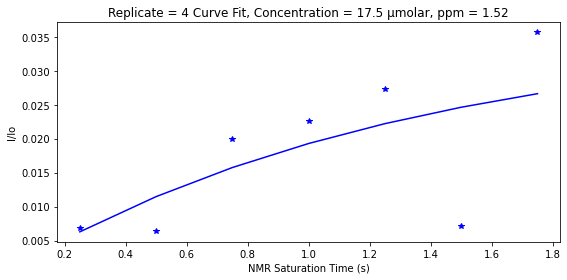

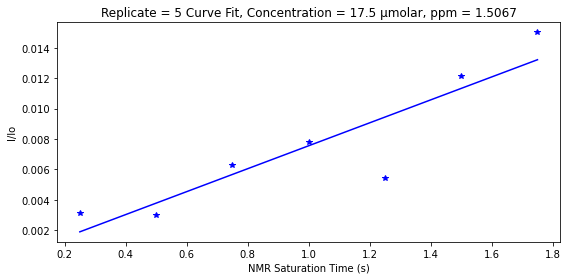

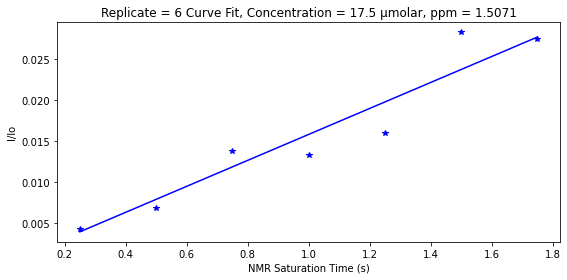

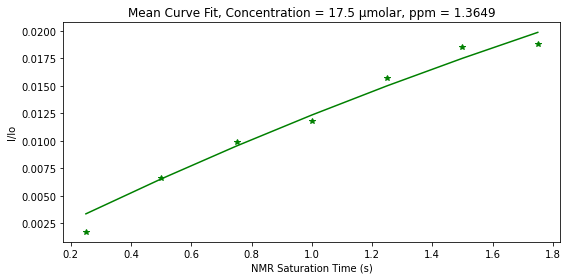

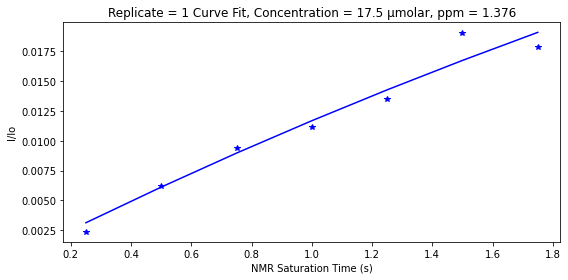

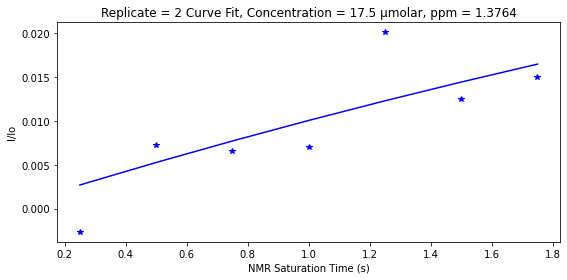

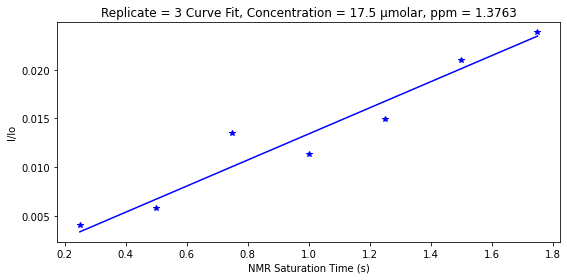

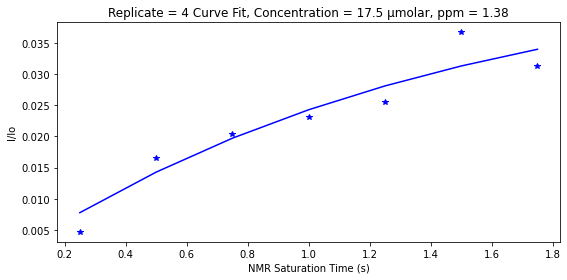

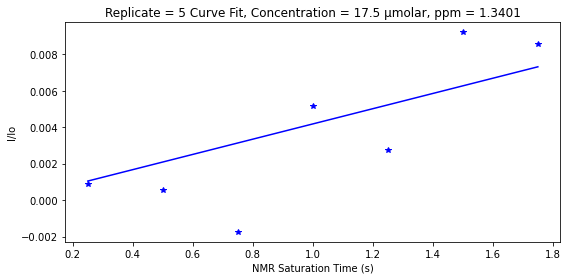

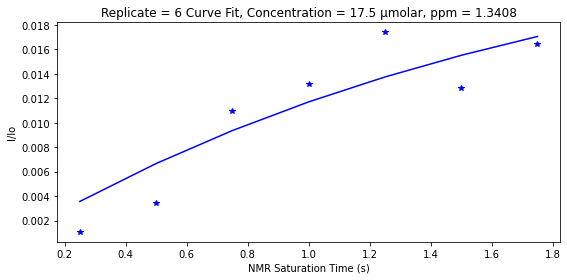

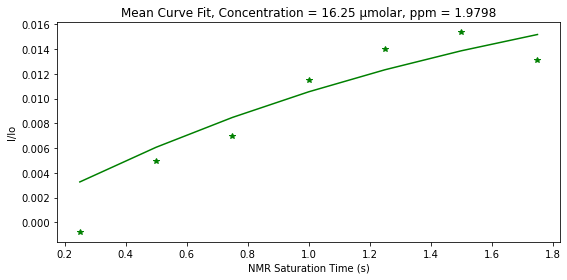

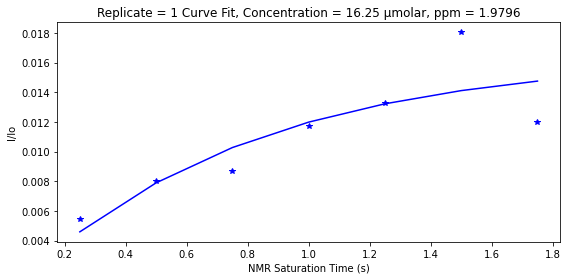

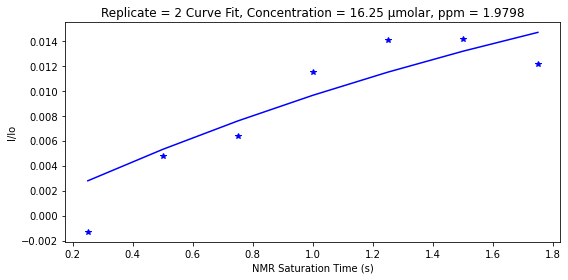

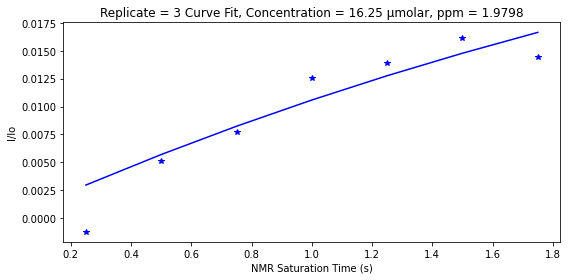

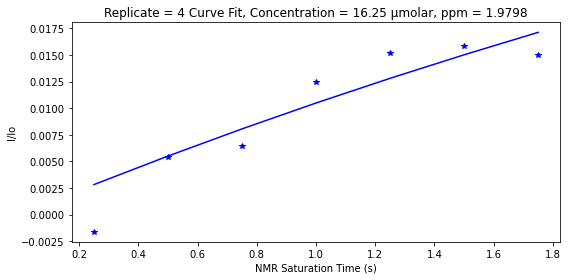

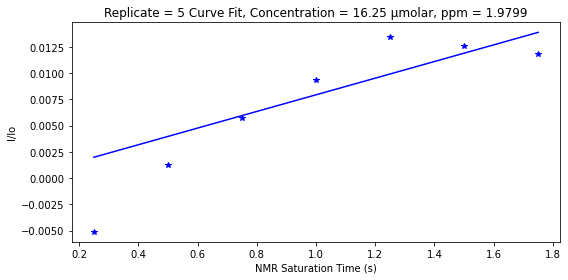

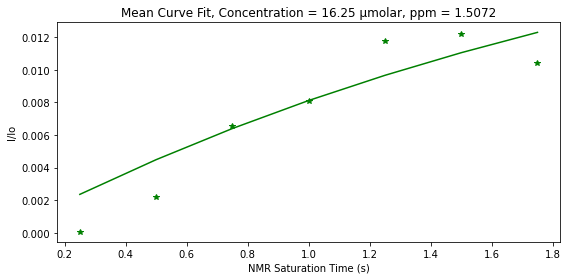

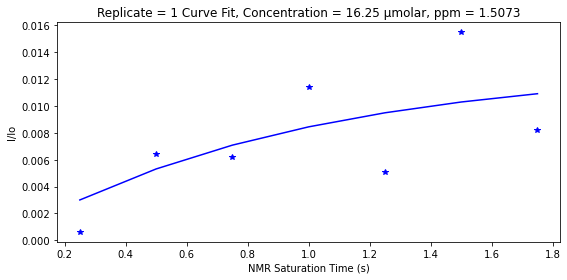

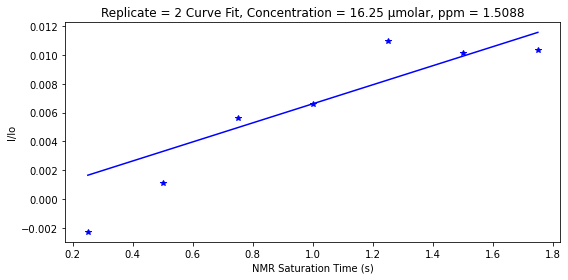

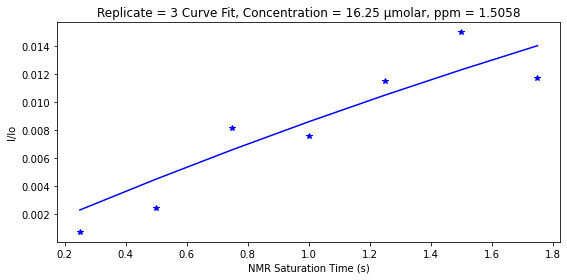

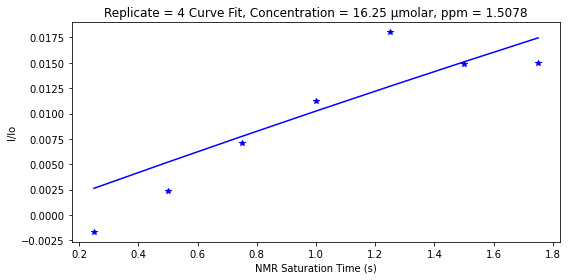

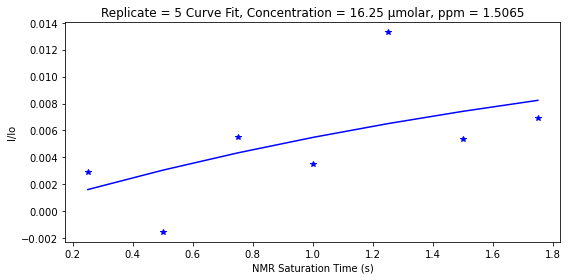

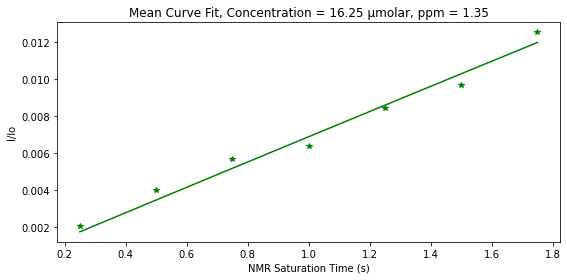

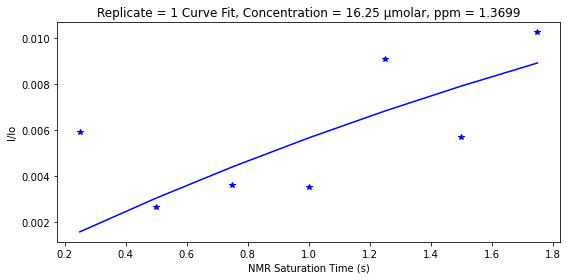

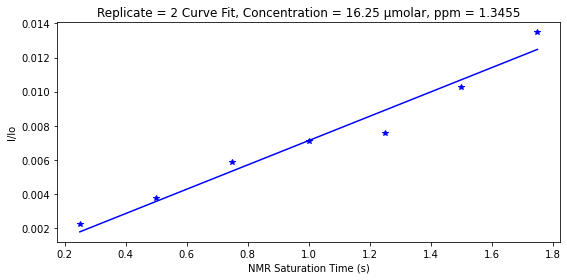

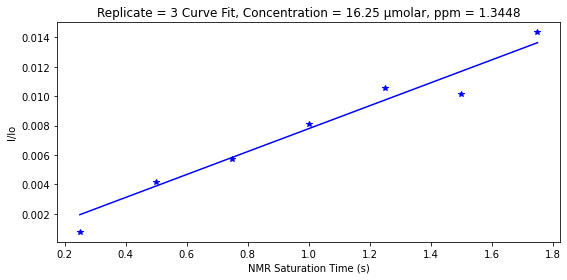

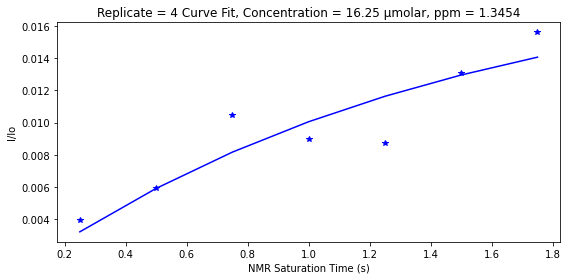

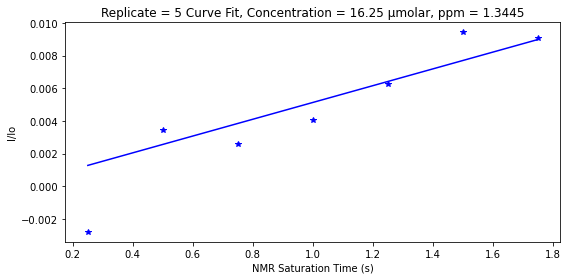

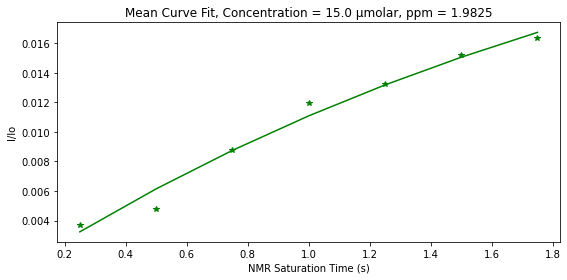

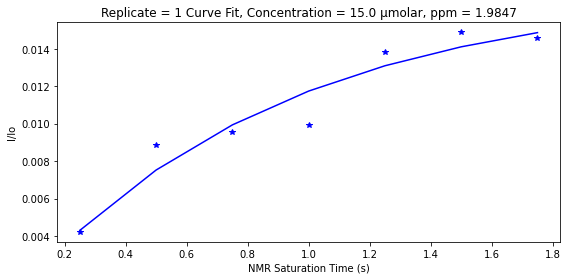

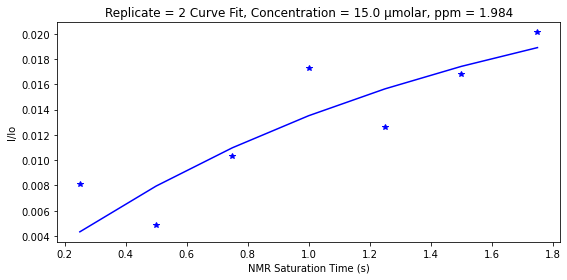

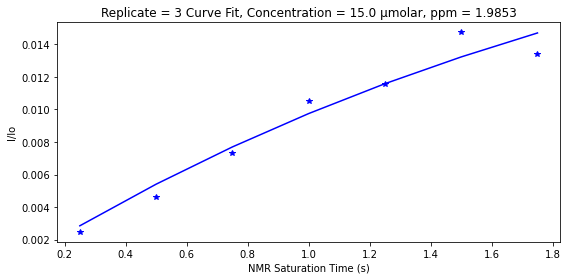

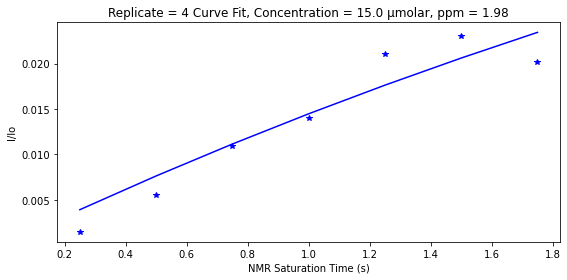

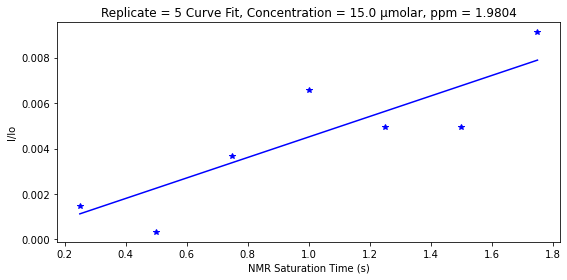

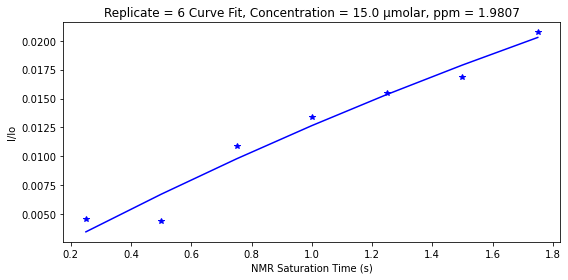

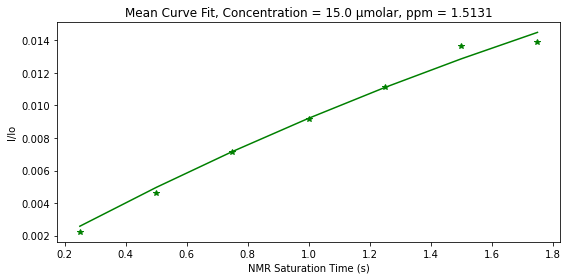

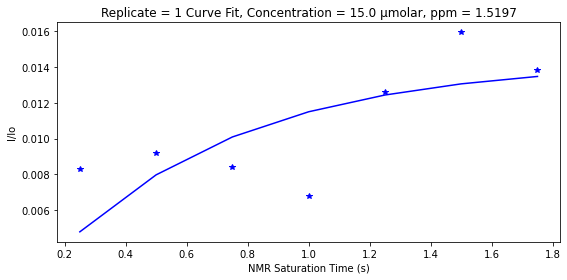

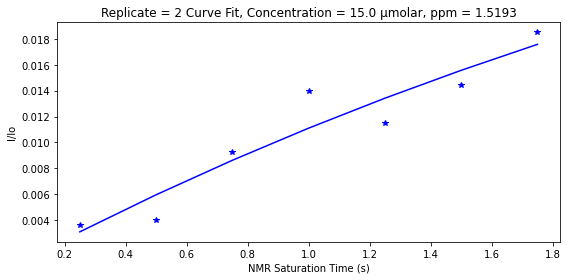

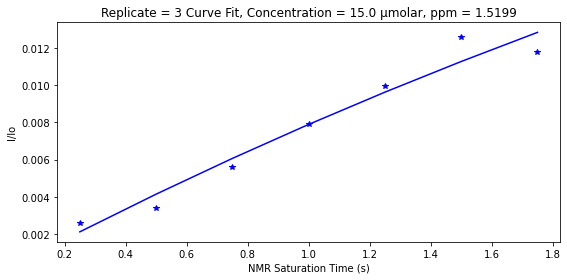

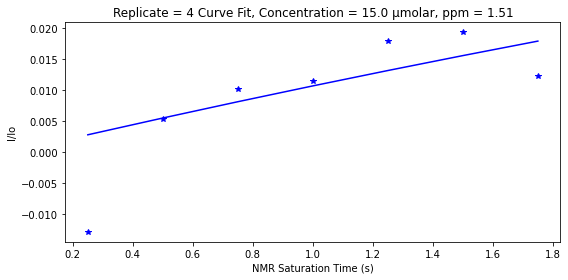

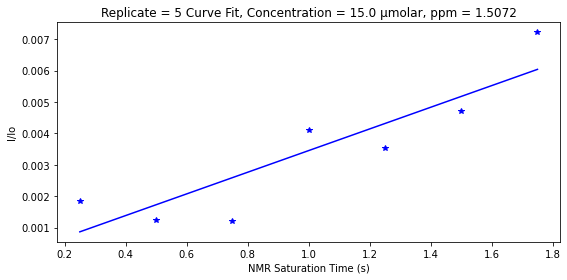

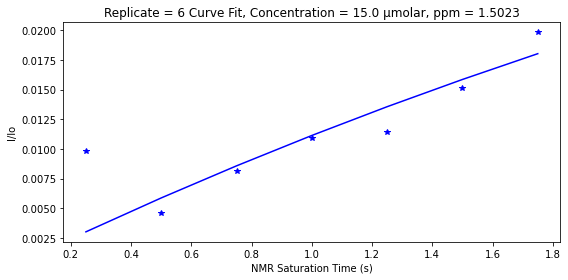

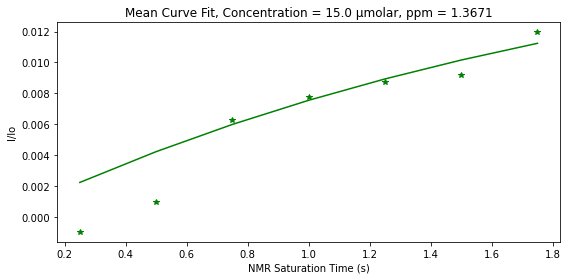

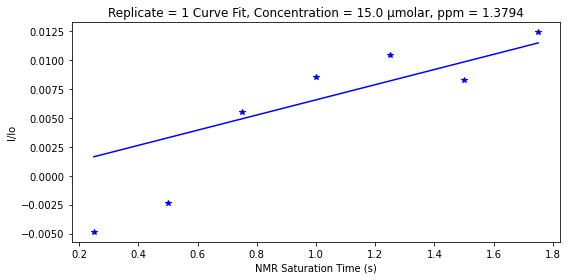

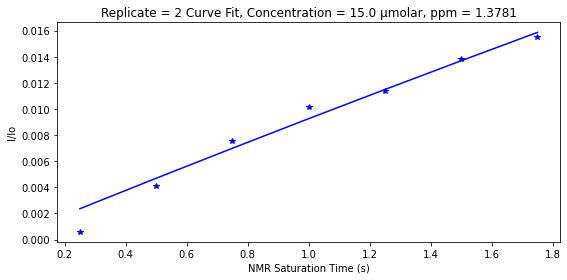

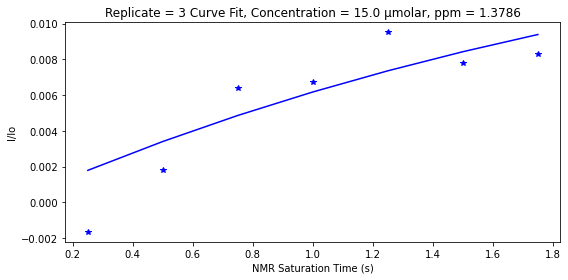

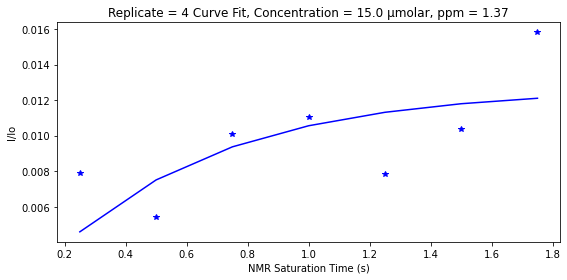

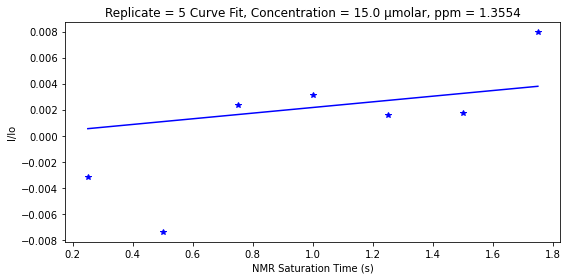

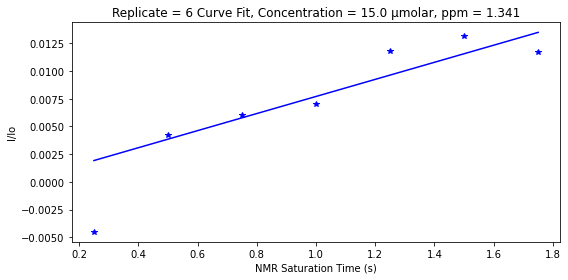

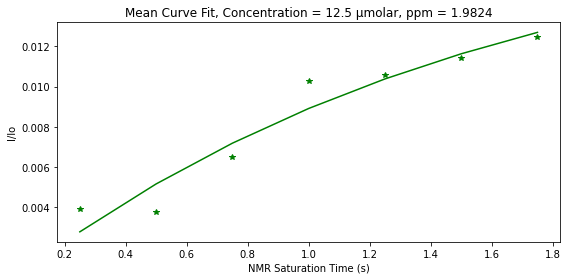

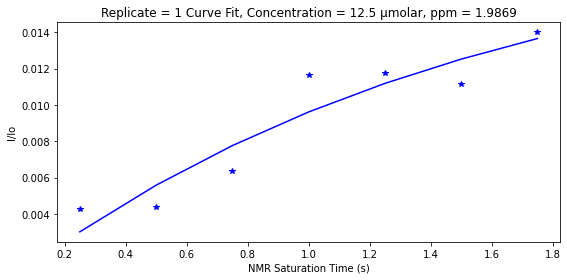

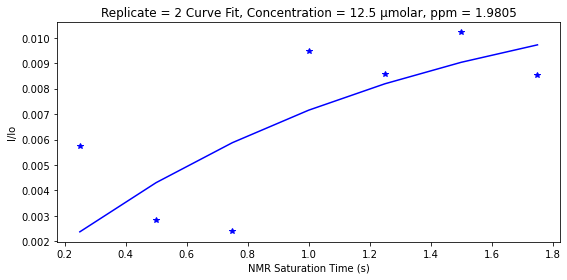

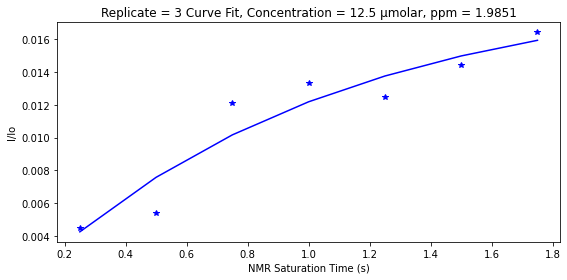

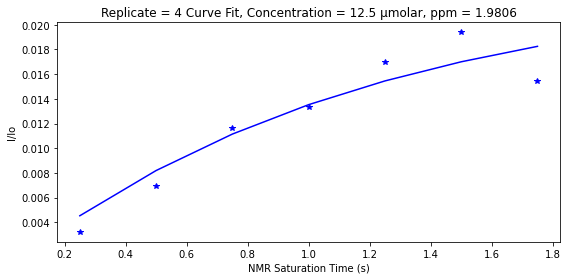

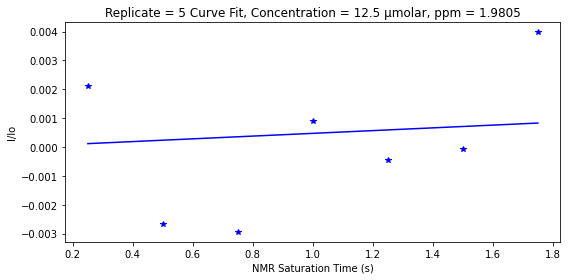

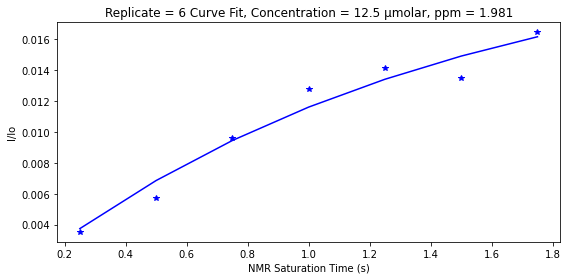

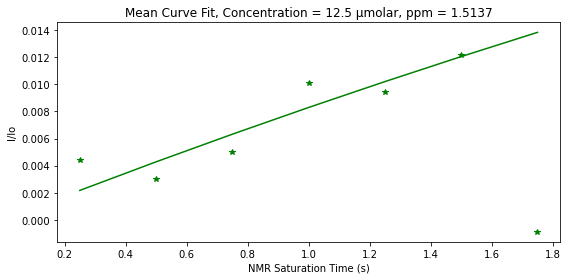

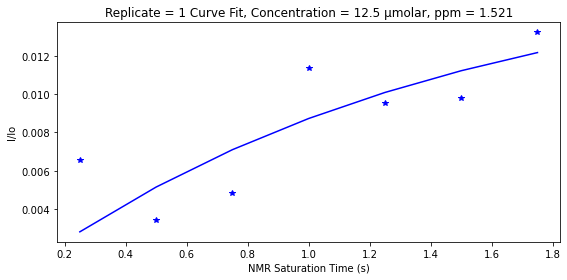

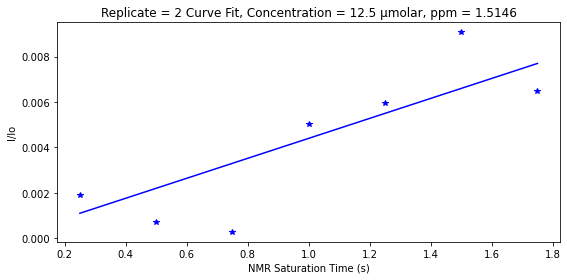

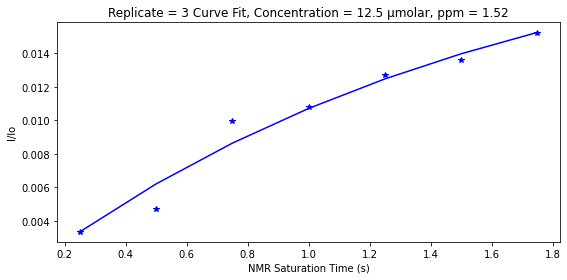

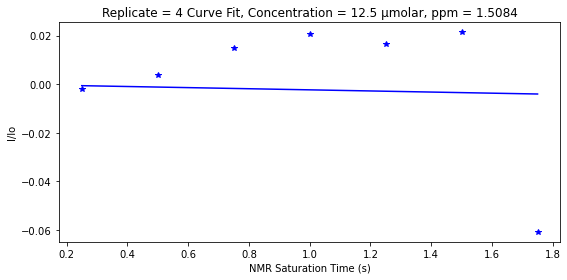

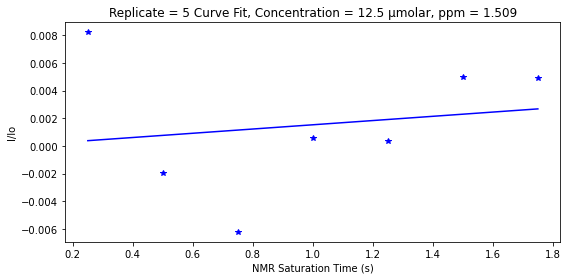

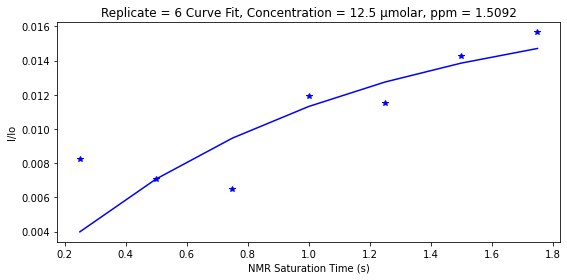

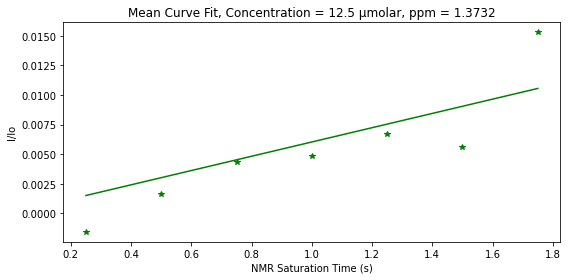

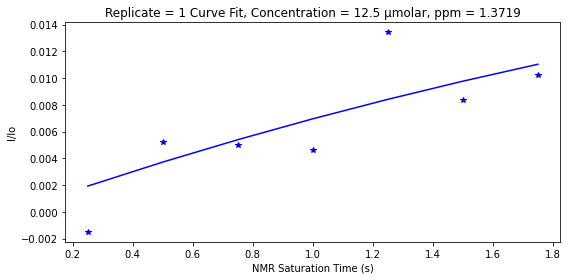

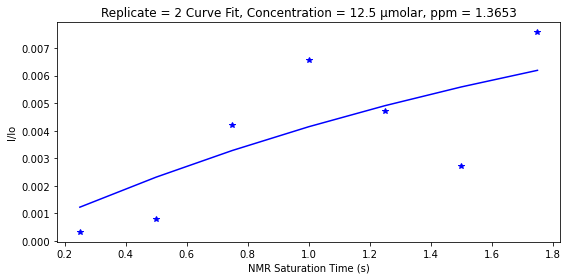

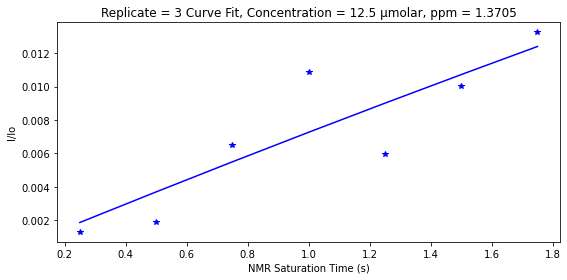

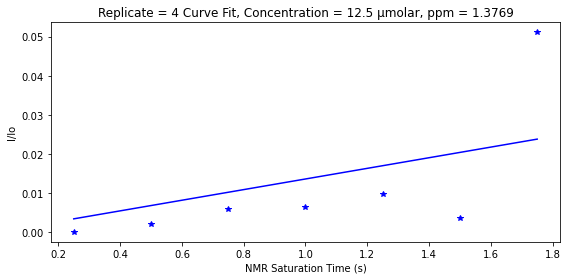

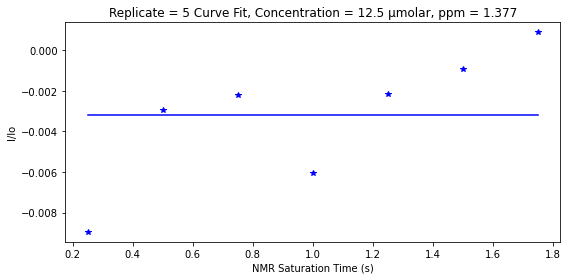

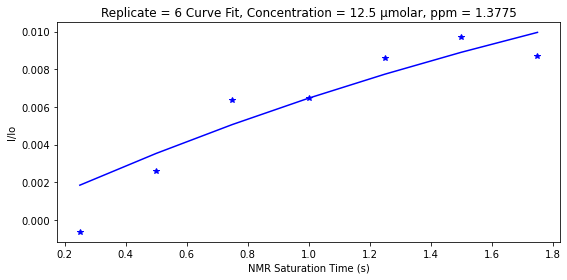

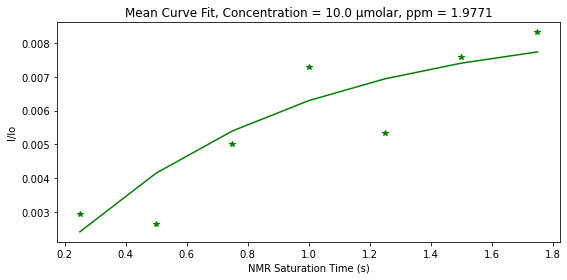

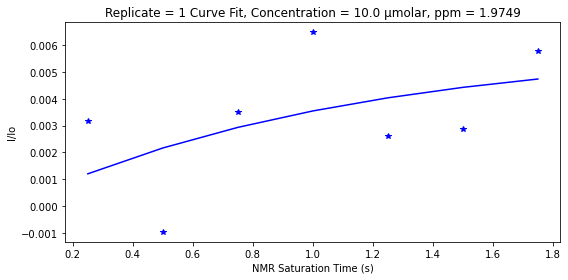

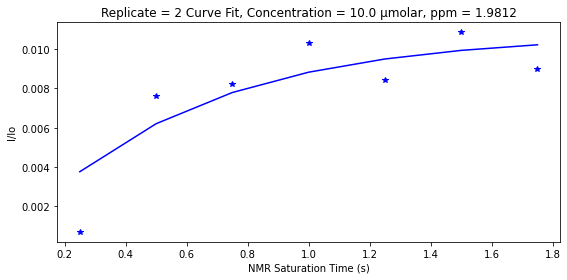

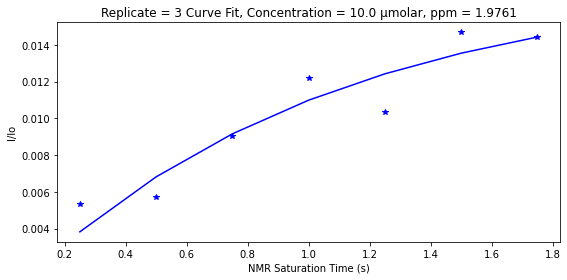

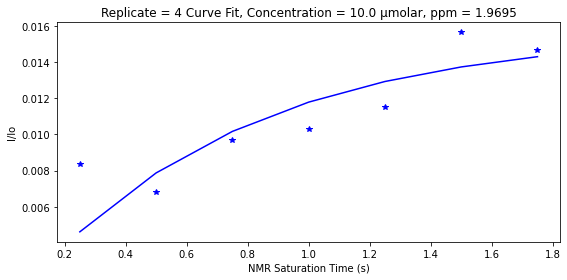

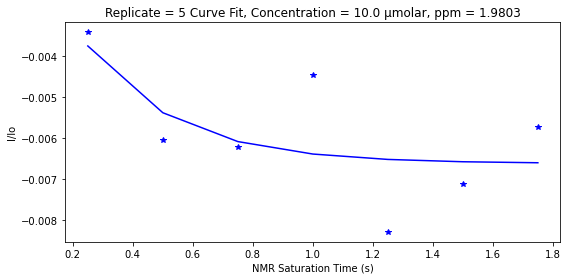

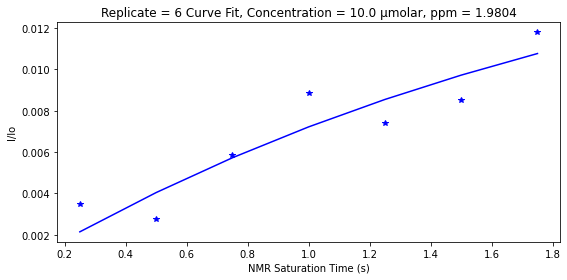

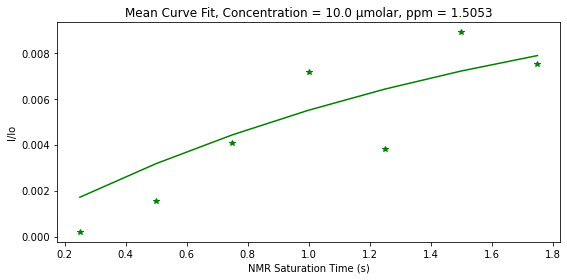

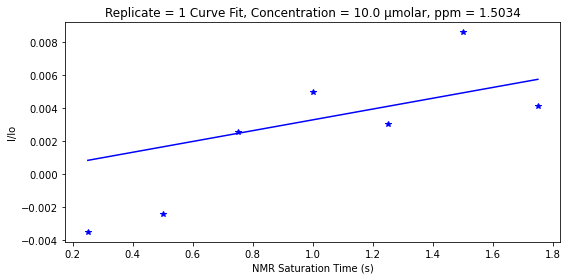

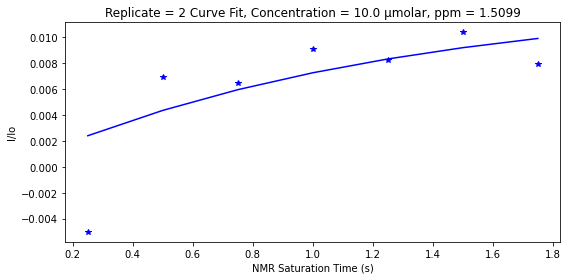

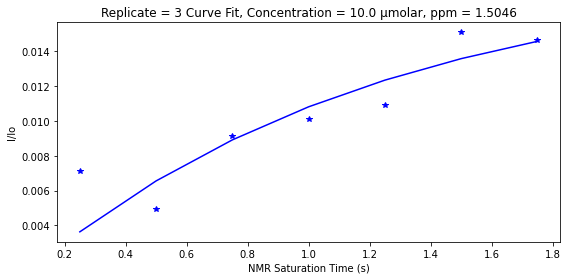

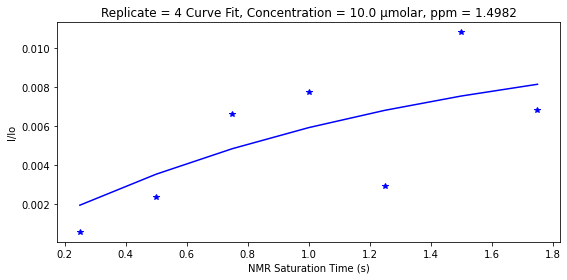

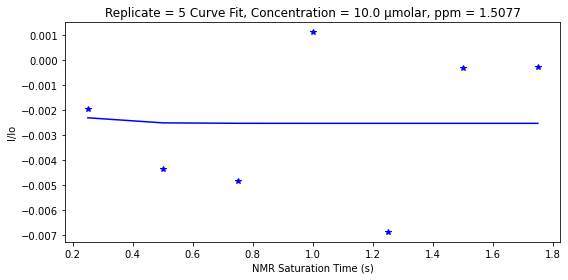

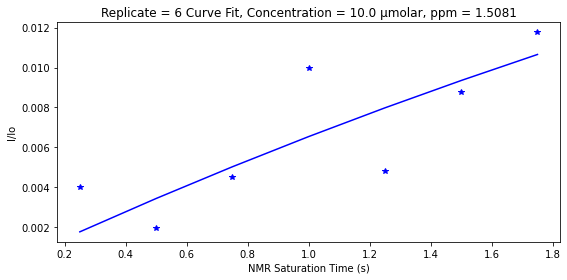

In [106]:
#Assign unique protons to a list to use for subsetting the df via the shortcut multi-index index slicing method
unique_protons = stats_df_replicates.proton_peak_index.unique().tolist()
unique_concentrations = stats_df_replicates.concentration.unique().tolist()
unique_replicates = stats_df_replicates.replicate.unique().tolist()
ppm_index = stats_df_replicates['ppm']

#----------------------------------------
#can initialize lists to store these values, but we don't need this anymore, this version of the code appends data right to the parent dataframes
# sse_replicate_list = []
# sse_bar_list = []
# amp_factor_inst_replicate_list = []
# amp_factor_inst_bar_list = []
#-----------------------------------------

# Preparing to curve fit, export the curve fit plots to a file, and tabulate final results ------------------------------

# Define a new output directory for the plots for the current book title
output_directory2 = "{}/curve_fit_plots_from_{}".format(output_directory,current_book_title)

# Make the output directory if there isn't already one for the curve_fit_plots
if not os.path.exists(output_directory2):
    os.makedirs(output_directory2)

print('Exporting all mean and individual curve fit figures to an output directory... this may take a moment.')    
    
for c in unique_concentrations:
    for p in unique_protons:        
        
        #COMPLETE MEAN CURVE FITTING OPERATIONS PER PROTON & PER CONCENTRATION
        
        # subset the df into the data for one graph, via index slice based on the current peak and concentration
        one_graph_data_mean = stats_df_mean.loc[idx[c, :, p]]
        
        #Make a boolean significance mask based on the one graph subset, for calculating parameters based on only significant pts
        boolean_sig_mask = one_graph_data_mean.significance == True
        
        #assign ALL datapoints and ALL data times to test_data variables for this ONE GRAPH
        all_yikj_bar = one_graph_data_mean['yikj_bar']
        all_sat_time = np.asarray(all_yikj_bar.index.get_level_values(1))

        #apply boolean significance mask to create the data to be used for actual curve fitting/parameter generation
        significant_yikj_bar = all_yikj_bar[boolean_sig_mask]
        significant_sat_time = all_sat_time[boolean_sig_mask]

        # grab the current mean ppm for this graph to use in naming and plotting
        ppm_bar = one_graph_data_mean['ppm']['mean'].values.mean().astype(float).round(4)

        # this will skip the graphing and analysis for cases where an insignificant proton peak has been removed from consideration PREVIOUSLY due to cutoff
        if all_yikj_bar.size == 0: continue

        # initial guess for alpha and beta (applies equally to replicate operations below)
        initial_guess = np.asarray([1, 1])

        # Generate best alpha & beta parameters for data based on only significant pts, for the current proton and concentration, optimizing for minimization of square error via least squares levenburg marquadt algorithm
        best_param_vals_bar, covar_bar = curve_fit(y_hat_fit, significant_sat_time, significant_yikj_bar, p0 = initial_guess, method = 'lm', maxfev=5000)

        # calculate ultimate sum of square errors after minimization for each time point
        sse_bar = np.square(y_hat_fit(significant_sat_time, *best_param_vals_bar) - significant_yikj_bar)
#         sse_bar_list.append(sse_bar)

        #append sum of square error calculated for this graph to the PARENT mean dataframe at this c and p
        stats_df_mean.loc[idx[c, :, p], ('SSE_bar')] = sse_bar.sum()

        # append best parameters to variables, and then generate the instantaneous amplification factor 
        a_kj_bar = best_param_vals_bar[0]
        b_kj_bar = best_param_vals_bar[1]

        amp_factor_instantaneous_bar = a_kj_bar * b_kj_bar
#         amp_factor_inst_bar_list.append(amp_factor_instantaneous_bar)
        
        #append instantaneous amplification factor calculated to the PARENT mean dataframe, for all datapoints in this graph
        stats_df_mean.loc[idx[c, :, p], ('AFo_bar')] = [amp_factor_instantaneous_bar]*(len(all_yikj_bar))
        
        # define file name for curve fits by mean
        output_file_name_figsmean = "{}/mean_concentration{}_ppm{}_CurveFit.png".format(output_directory2, c, ppm_bar)

        # PLOT MEAN DF CURVE FITS with the original data and save to file
        fig1, (ax1) = plt.subplots(1, figsize = (8, 4))
        ax1.plot(all_sat_time, y_hat_fit(all_sat_time, a_kj_bar, b_kj_bar), 'g-', label='model_w_significant_params')
        ax1.plot(all_sat_time, all_yikj_bar, 'g*', label='all_raw_data')
        ax1.set_title('Mean Curve Fit, Concentration = {} µmolar, ppm = {}'.format(c,ppm_bar))
        ax1.set_xlabel('NMR Saturation Time (s)')
        ax1.set_ylabel('I/Io')
        fig1.tight_layout()

        # export to file
        fig1.savefig(output_file_name_figsmean, dpi=300)
            
        for r in unique_replicates:
        
            #COMPLETE REPLICATE SPECIFIC CURVE FIT OPERATIONS - subset the df via index slice based on the current peak, concentration, and replicate
            one_graph_data = stats_df_replicates.loc[(stats_df_replicates['proton_peak_index'] == p) & (stats_df_replicates['concentration'] == c) & (stats_df_replicates['replicate'] == r)]

            # define the experimental data to compare square error with (amp_factor * atten_corr_int), for y_ikj
            y_ikj = one_graph_data['yikj']
            
            #this will skip the graphing and analysis for cases where a proton peak has been removed from consideration 
            if y_ikj.size == 0: continue
            
            # define sat_time to be used for the x_data 
            sat_time = one_graph_data[['sat_time']].values.ravel()

            #Fit Curve for curren proton, concentration and replicate, optimizing for minimization of square error via least squares levenburg marquadt algorithm
            best_param_vals, covar = curve_fit(y_hat_fit, sat_time, y_ikj, p0 = initial_guess, method = 'lm', maxfev=5000)
#             print('Best Alpha and Beta Vals for this Replicate: {}'.format(best_vals))
            
            #calculate ultimate sum of square errors after minimization for each time point, and append to list
            sse = np.square(y_hat_fit(sat_time, *best_param_vals) - y_ikj)
#             print('SSE for this Replicate: {}'.format(sse))
#             sse_replicate_list.append(sse)
            
            #appends sum of square error calculated to the PARENT stats replicate dataframe, summed for all datapoints in this graph
            stats_df_replicates.loc[(stats_df_replicates['proton_peak_index'] == p) & (stats_df_replicates['concentration'] == c) & (stats_df_replicates['replicate'] == r), ('SSE')] = sse.sum()    
            
            # solve for the instantaneous amplification factor
            a_kj = best_param_vals[0]
            b_kj = best_param_vals[1]
            amp_factor_instantaneous = a_kj * b_kj
#             amp_factor_inst_replicate_list.append(amp_factor_instantaneous)
            
            #appends instantaneous amplification factor calculated to the PARENT stats replicate dataframe, for all datapoints in this graph
            stats_df_replicates.loc[(stats_df_replicates['proton_peak_index'] == p) & (stats_df_replicates['concentration'] == c) & (stats_df_replicates['replicate'] == r), ('AFo')] = [amp_factor_instantaneous]*(len(y_ikj))
            
            #determine mean current ppm across the sat_times for this replicate so that we can add it to the file name
            mean_current_ppm = one_graph_data.loc[(one_graph_data['concentration'] == c) & (one_graph_data['proton_peak_index'] == p) & (one_graph_data['replicate'] == r)]['ppm'].mean().astype(float).round(4)    
            
            # file name for curve fits by replicate 
            output_file_name_figsrep = "{}/replicate{}_concentration{}_ppm{}_CurveFit.png".format(output_directory2, r, c, mean_current_ppm)
            
            # PLOT CURVE FITS with original data per Replicate and save to file
            fig2, (ax2) = plt.subplots(1, figsize = (8, 4))
            ax2.plot(sat_time, y_hat_fit(sat_time, *best_param_vals), 'b-', label='data')
            ax2.plot(sat_time, y_ikj, 'b*', label='data')
            ax2.set_title('Replicate = {} Curve Fit, Concentration = {} µmolar, ppm = {}'.format(r, c, mean_current_ppm))
            ax2.set_xlabel('NMR Saturation Time (s)')
            ax2.set_ylabel('I/Io')
            fig2.tight_layout()
            
            #export to file
            fig2.savefig(output_file_name_figsrep, dpi=300)

print('Export of all figures to file complete!')            

In [107]:
#export final replicates table to an excel output
output_directory3 = "{}/data_tables_from_{}".format(output_directory,current_book_title)
output_file_name = "stats_analysis_output_replicate_{}.xlsx".format(current_book_title)

#make directory if there isn't already one for output 
if not os.path.exists(output_directory3):
    os.makedirs(output_directory3)
    
#export replicates final results table to a summary file in Excel
stats_df_replicates.to_excel(os.path.join(output_directory3, output_file_name))

#export mean final results table to a summary file in Excel
output_file_name = "stats_analysis_output_mean_{}.xlsx".format(current_book_title)
stats_df_mean.to_excel(os.path.join(output_directory3, output_file_name))

In [108]:
# The code below can be uncommented for easily "sanity checking" the subset data appended to the mean and replicate dataframes. -----------
# It's easier to use this code than the Excel files for quick checks and graph matching imo!
# To use, edit the values in the idx statement[conc, sat_time, proton_peak_index], and the col labels at the end ['SSE_bar'] (this can be removed if you want to see the whole subset for a graph).

# For Mean DataFrame
checking = stats_df_mean.loc[idx[12.5, :, 2]]['SSE_bar']
# print(checking)

# For Replicate DataFrame
checking_rep = stats_df_replicates.loc[(stats_df_replicates['proton_peak_index'] == 2) & (stats_df_replicates['concentration'] == 12.5) & (stats_df_replicates['replicate'] == 5)]['SSE']
# print(checking_rep)

